<a href="https://colab.research.google.com/github/CesarC15/projetoML/blob/main/src/deteccao_anomalias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup Infraestrutura e Dados**

In [1]:
pip install kagglehub[pandas-datasets] ydata-profiling imbalanced-learn seaborn matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.7/398.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.3 MB/s eta 0:00:00


In [2]:
import kagglehub
import pandas as pd
import numpy as np
import os
import math
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import LocalOutlierFactor
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
#Aquisição de Dados
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
file_path = os.path.join(path, 'creditcard.csv')

Using Colab cache for faster access to the 'creditcardfraud' dataset.


In [4]:
df = pd.read_csv(file_path)

print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [5]:
# --- Configurações Estéticas ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

# 1. Visão Geral Estrutural
print("--- Dimensões do Dataset ---")
print(f"Linhas: {df.shape[0]}")
print(f"Colunas: {df.shape[1]}\n")

print("--- Tipos de Dados ---")
display(df.info())

# 2. Verificação de Qualidade (Nulos e Duplicatas)
print("\n--- Verificação de Dados Faltantes ---")
missing_values = df.isnull().sum().sum()
print(f"Total de valores nulos: {missing_values}")
if missing_values > 0:
    print(df.isnull().sum()[df.isnull().sum() > 0])

print("\n--- Verificação de Duplicatas ---")
duplicates = df.duplicated().sum()
print(f"Linhas duplicadas: {duplicates} ({duplicates/len(df)*100:.2f}%)")

# Dica Profissional: Duplicatas no dataset de fraude podem ser transações reais repetidas
# ou erro de coleta. Se for removê-las, justifique.
# df.drop_duplicates(inplace=True) # Descomente se decidir remover

--- Dimensões do Dataset ---
Linhas: 284807
Colunas: 31

--- Tipos de Dados ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19   

None


--- Verificação de Dados Faltantes ---
Total de valores nulos: 0

--- Verificação de Duplicatas ---
Linhas duplicadas: 1081 (0.38%)


--- Distribuição das Classes ---
Genuínas (0): 284315 (99.8273%)
Fraudes (1):   492 (0.1727%)


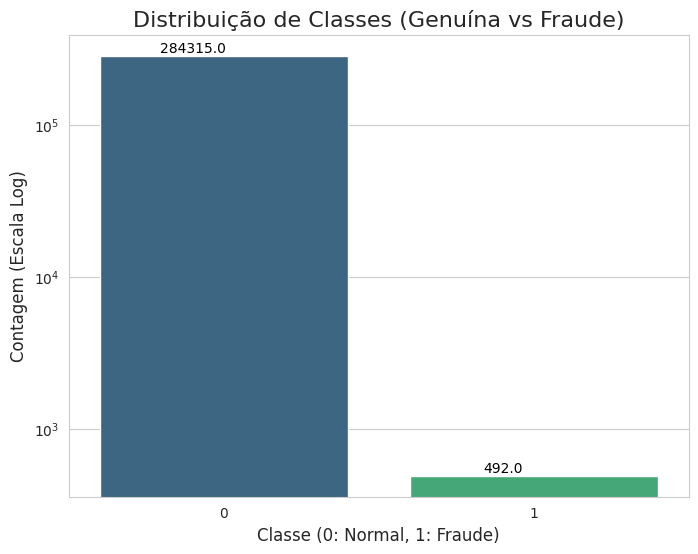

In [6]:
# Contagem das classes
class_counts = df['Class'].value_counts()
class_percentages = df['Class'].value_counts(normalize=True) * 100

print("--- Distribuição das Classes ---")
print(f"Genuínas (0): {class_counts[0]} ({class_percentages[0]:.4f}%)")
print(f"Fraudes (1):   {class_counts[1]} ({class_percentages[1]:.4f}%)")

# Visualização
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Class', data=df, hue='Class', palette='viridis', legend=False)
plt.title('Distribuição de Classes (Genuína vs Fraude)', fontsize=16)
plt.yscale('log') # Escala logarítmica ajuda a ver a classe minoritária melhor
plt.xlabel('Classe (0: Normal, 1: Fraude)', fontsize=12)
plt.ylabel('Contagem (Escala Log)', fontsize=12)

# Adicionando anotações
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.3, p.get_height()),
                ha='center', va='bottom', color='black')
plt.show()

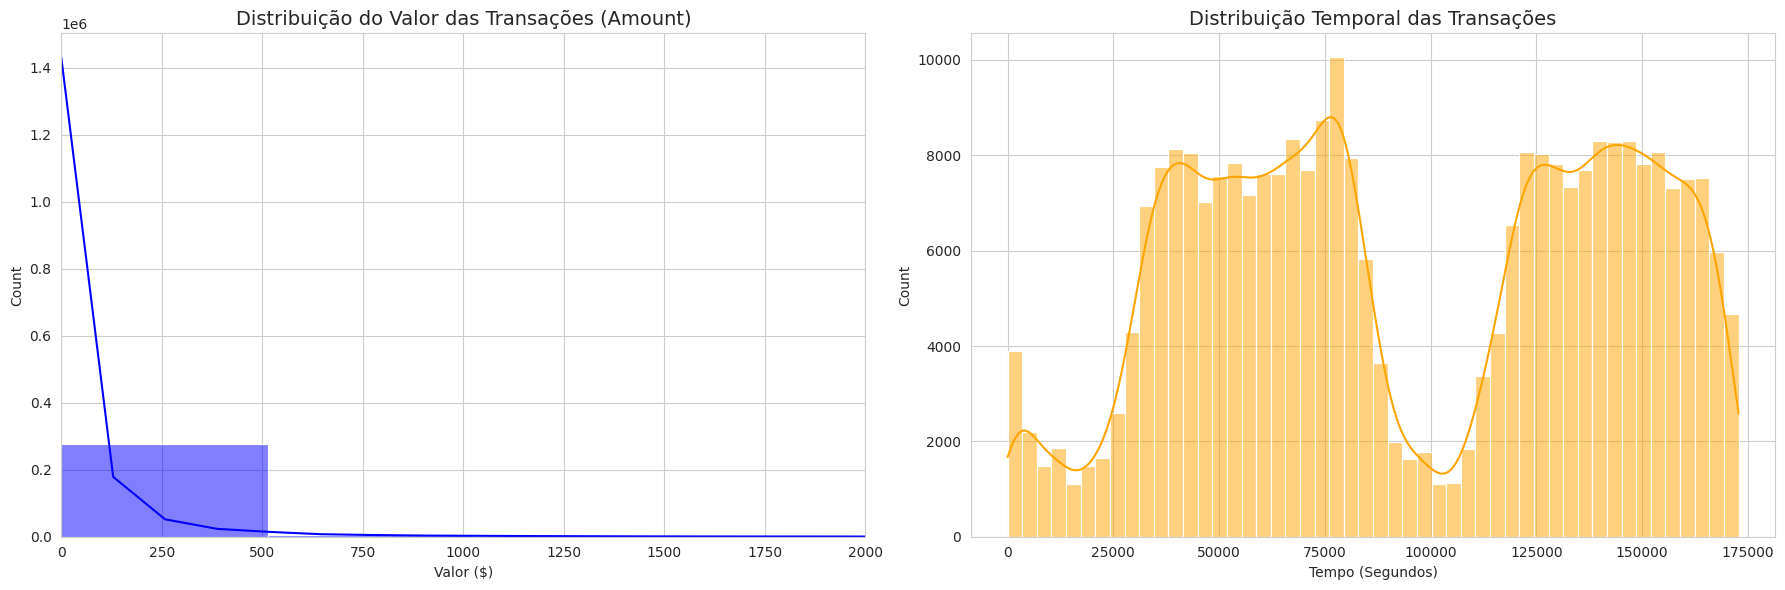

--- Estatísticas de Valor (Amount) por Classe ---


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,284315.0,88.291022,250.105092,0.0,5.65,22.00,77.05,25691.16
1,492.0,122.211321,256.683288,0.0,1.00,9.25,105.89,2125.87


In [7]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Análise da Feature 'Amount' (Valor da Transação)
sns.histplot(df['Amount'], bins=50, kde=True, ax=ax[0], color='blue')
ax[0].set_title('Distribuição do Valor das Transações (Amount)', fontsize=14)
ax[0].set_xlim([0, 2000]) # Limitando para ver melhor a maioria das transações
ax[0].set_xlabel('Valor ($)')

# Análise da Feature 'Time' (Tempo desde a primeira transação)
# Convertendo segundos para horas para facilitar a leitura (aprox)
sns.histplot(df['Time'], bins=50, kde=True, ax=ax[1], color='orange')
ax[1].set_title('Distribuição Temporal das Transações', fontsize=14)
ax[1].set_xlabel('Tempo (Segundos)')

plt.tight_layout()
plt.show()

# Estatísticas descritivas comparando Fraude vs Genuína para Amount
print("--- Estatísticas de Valor (Amount) por Classe ---")
display(df.groupby('Class')['Amount'].describe())

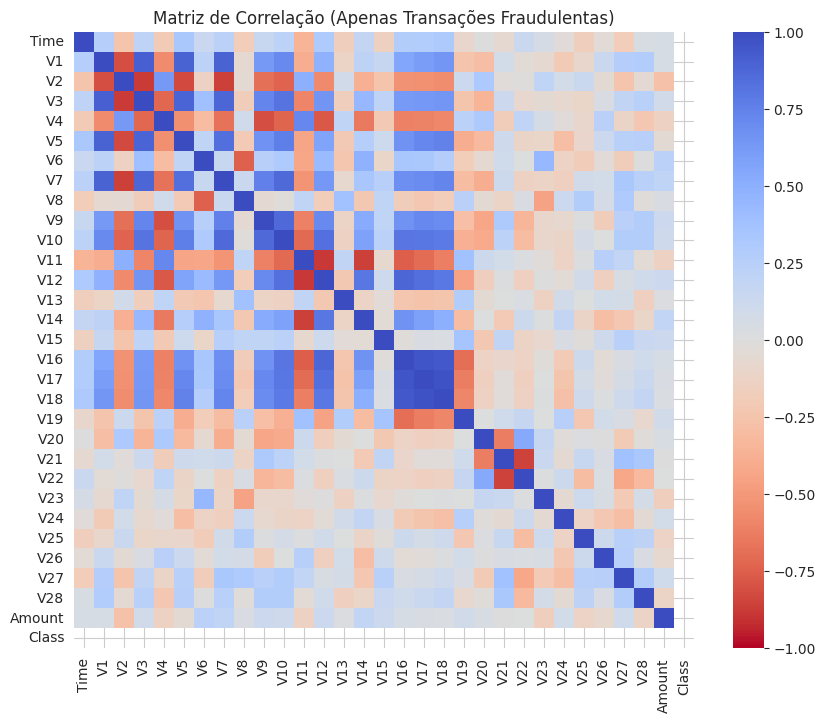

In [8]:
plt.figure(figsize=(10, 8))
# Correlação focada nas transações de Fraude
corr_fraud = df[df['Class'] == 1].corr()
sns.heatmap(corr_fraud, cmap='coolwarm_r', annot=False, vmin=-1, vmax=1)
plt.title('Matriz de Correlação (Apenas Transações Fraudulentas)')
plt.show()

Analisando 28 variáveis do PCA...


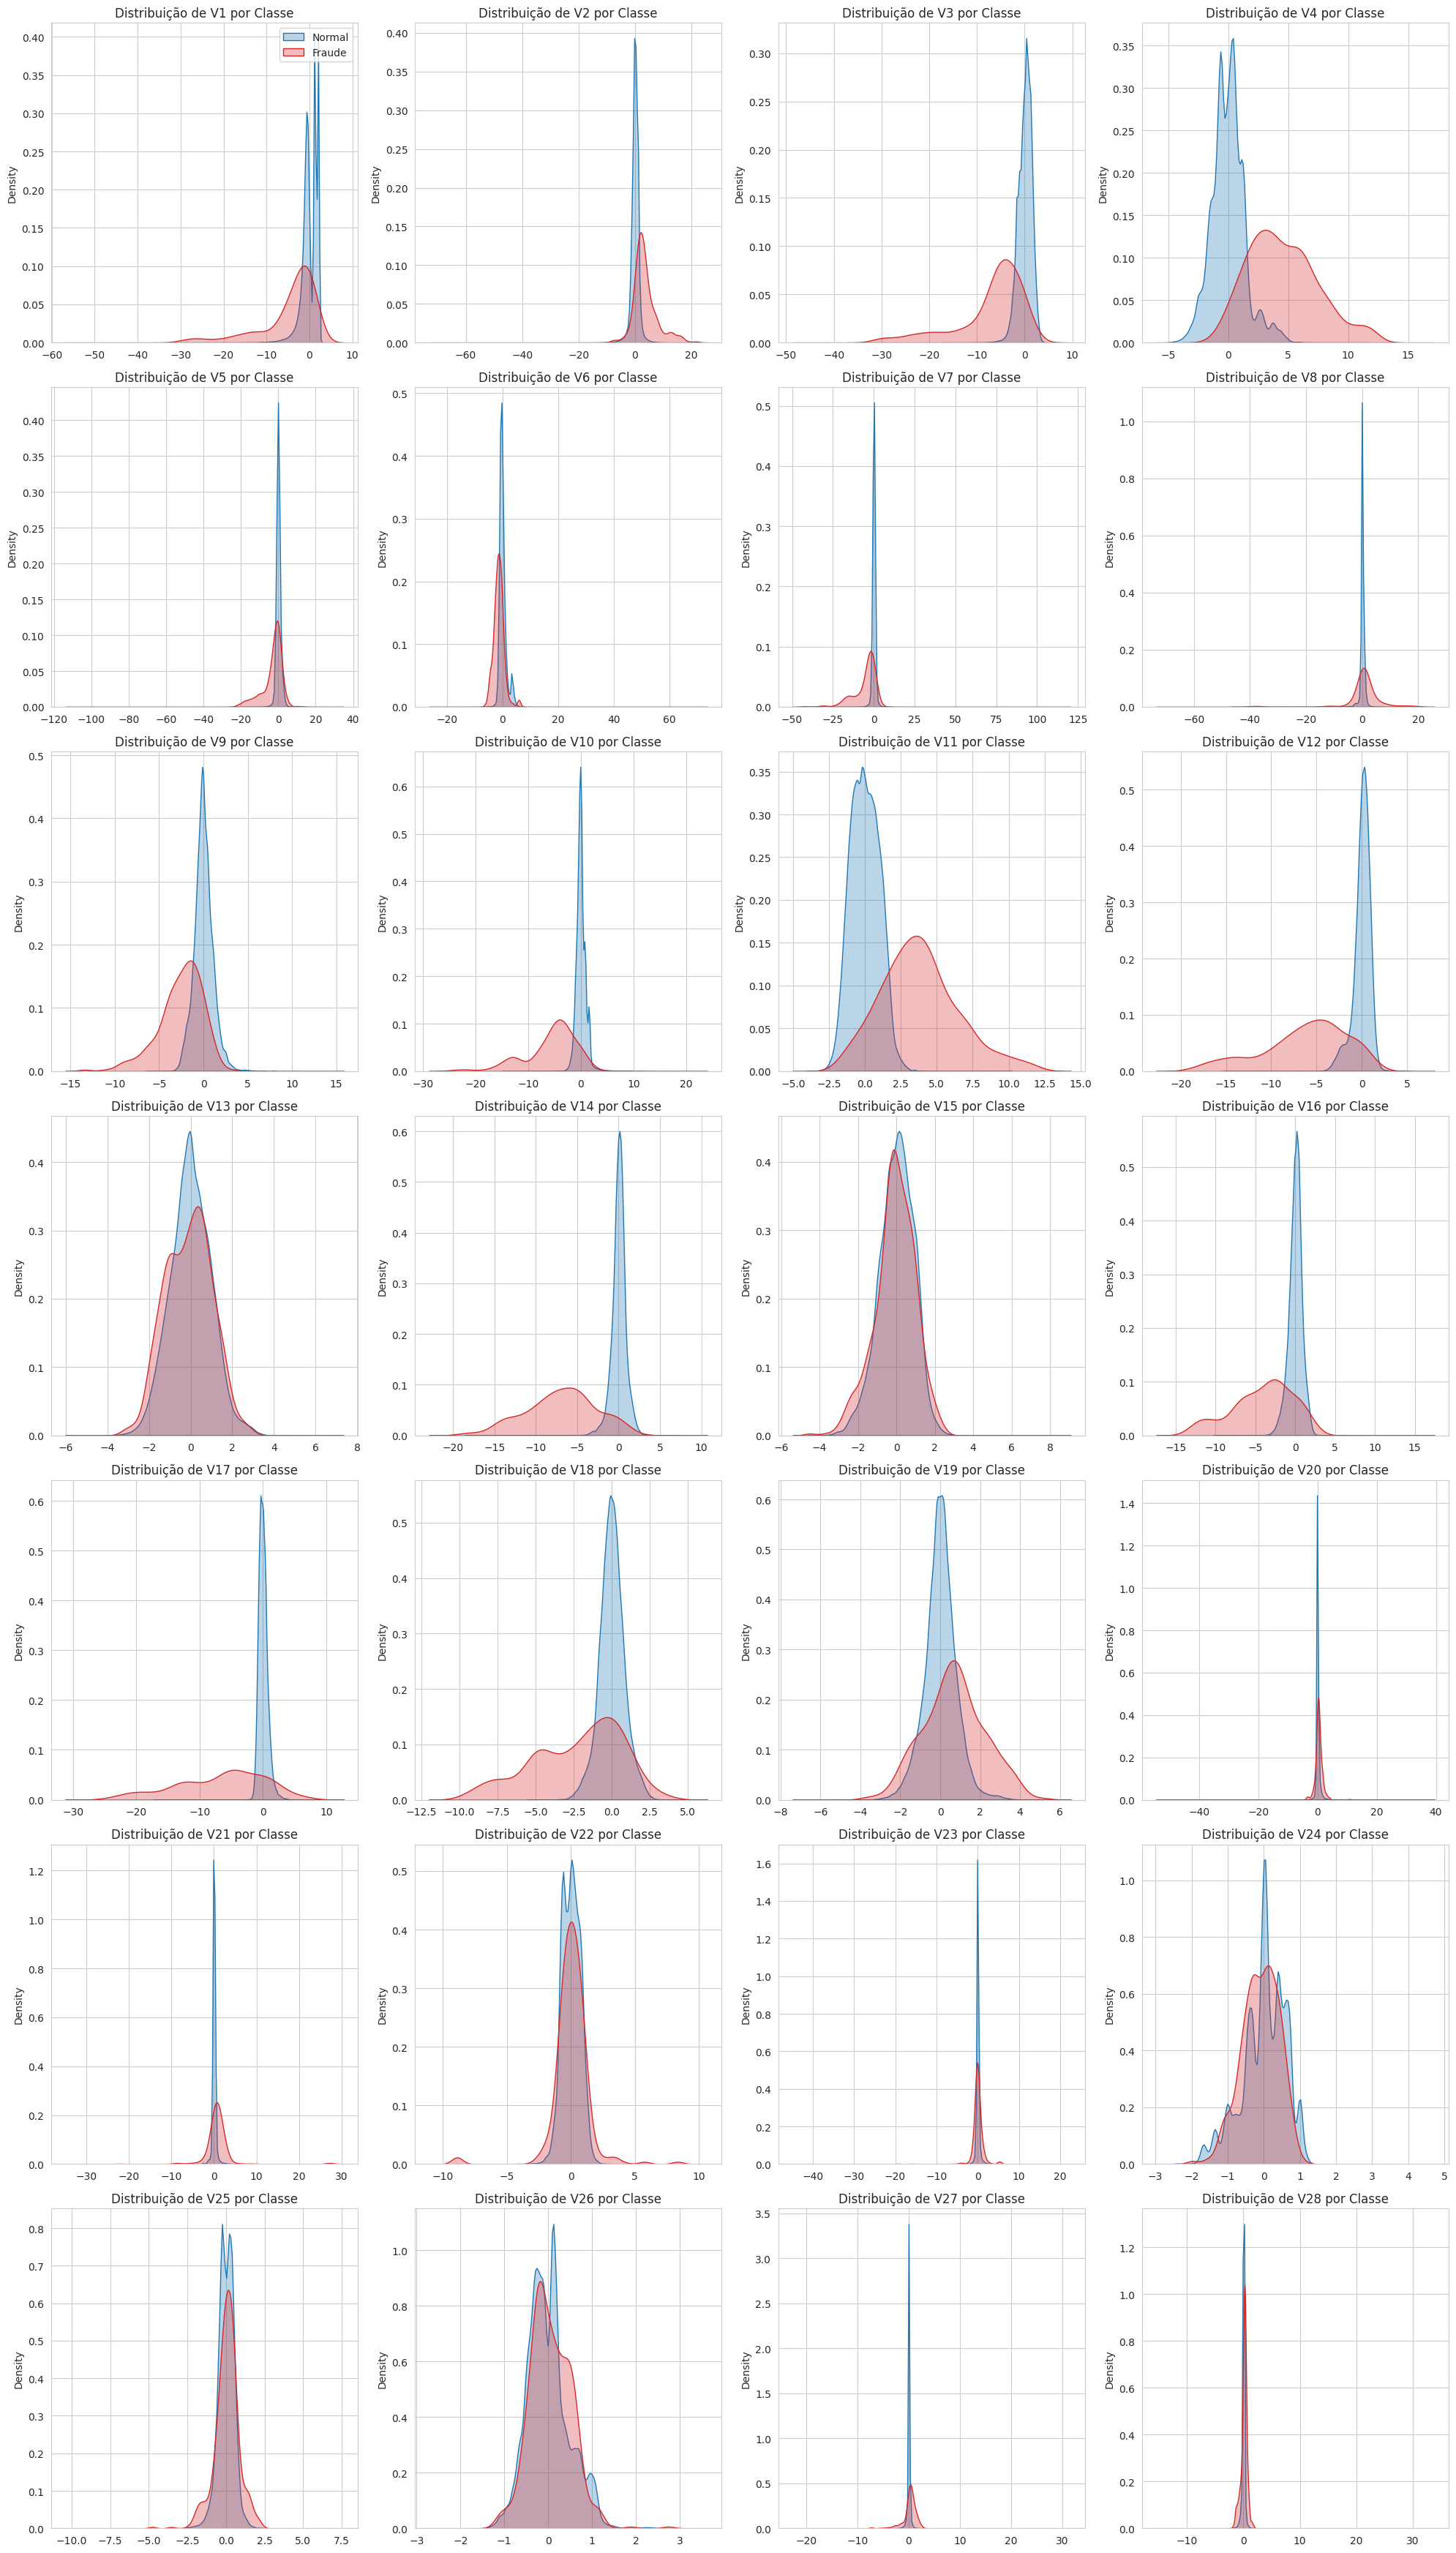

In [9]:
# 1. Cria a lista de 'V1' até 'V28' automaticamente
cols_pca = [f'V{i}' for i in range(1, 29)]
print(f"Analisando {len(cols_pca)} variáveis do PCA...")

# 2. Configura o tamanho da figura (Grid 7x4)
n_cols = 4
n_rows = math.ceil(len(cols_pca) / n_cols)

plt.figure(figsize=(20, 5 * n_rows)) # Ajusta altura baseada no número de linhas

# 3. Loop para gerar os gráficos
for i, col in enumerate(cols_pca):
    plt.subplot(n_rows, n_cols, i+1)

    # Plot: Normal (Azul) vs Fraude (Vermelho)
    # fill=True preenche a área, alpha deixa transparente para ver sobreposição
    sns.kdeplot(df[df['Class'] == 0][col], label="Normal", color='#1f77b4', fill=True, alpha=0.3)
    sns.kdeplot(df[df['Class'] == 1][col], label="Fraude", color='#d62728', fill=True, alpha=0.3)

    plt.title(f'Distribuição de {col} por Classe', fontsize=12)
    plt.xlabel(None) # Remove label X para limpar o visual

    # Coloca a legenda apenas no primeiro gráfico para não poluir
    if i == 0:
        plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

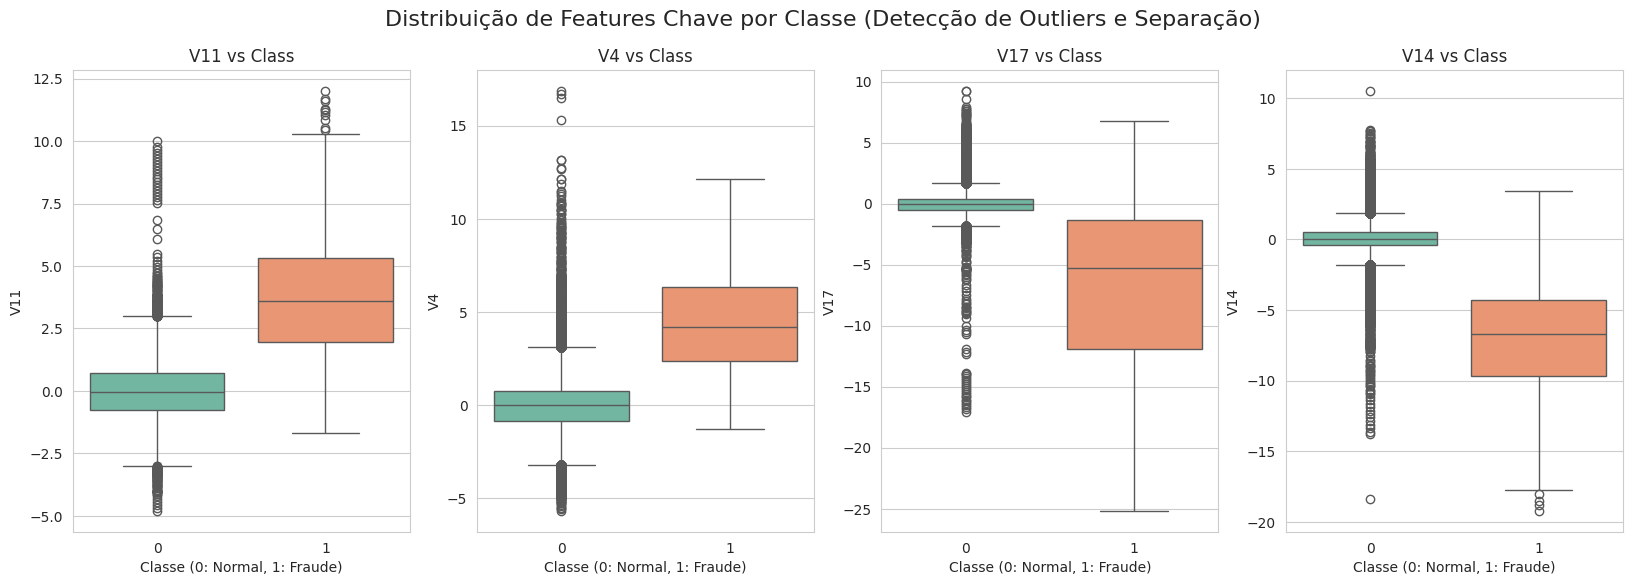

In [10]:
# Selecionando features com alta correlação (positiva e negativa) para inspeção
features_to_plot = ['V11', 'V4', 'V17', 'V14']

fig, axes = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle('Distribuição de Features Chave por Classe (Detecção de Outliers e Separação)', fontsize=16)

for i, col in enumerate(features_to_plot):
    # CORREÇÃO AQUI: Adicionado hue="Class" e legend=False
    sns.boxplot(x="Class", y=col, data=df, ax=axes[i], hue="Class", palette="Set2", legend=False)

    axes[i].set_title(f'{col} vs Class')
    axes[i].set_xlabel('Classe (0: Normal, 1: Fraude)')

plt.show()

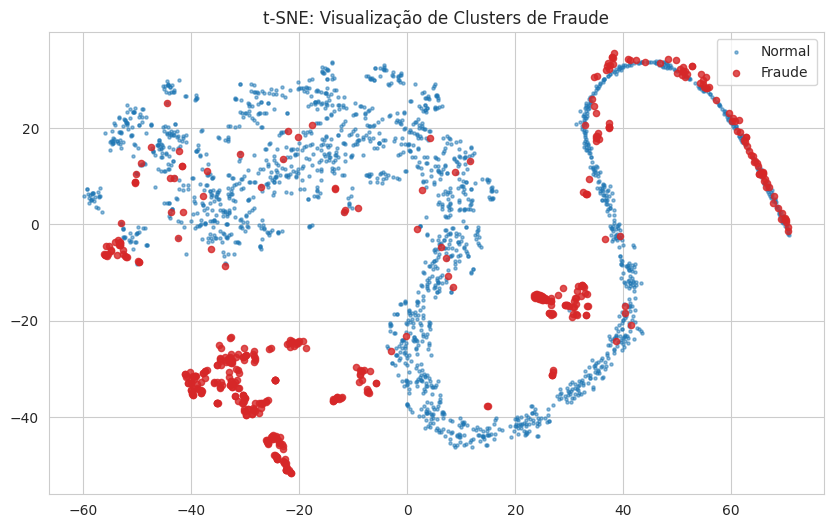

In [11]:
# Amostra para visualização (ex: 2000 normais + todas as fraudes)
df_sample = pd.concat([
    df[df['Class'] == 0].sample(2000, random_state=42),
    df[df['Class'] == 1]
])

X_sample = df_sample.drop(['Class', 'Time'], axis=1) # Time costuma não ajudar no t-SNE sem tratamento
y_sample = df_sample['Class']

# Executando t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_sample)

# Plotando
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[y_sample==0, 0], X_tsne[y_sample==0, 1], c='#1f77b4', label='Normal', alpha=0.5, s=5)
plt.scatter(X_tsne[y_sample==1, 0], X_tsne[y_sample==1, 1], c='#d62728', label='Fraude', alpha=0.8, s=20)
plt.title('t-SNE: Visualização de Clusters de Fraude')
plt.legend()
plt.show()

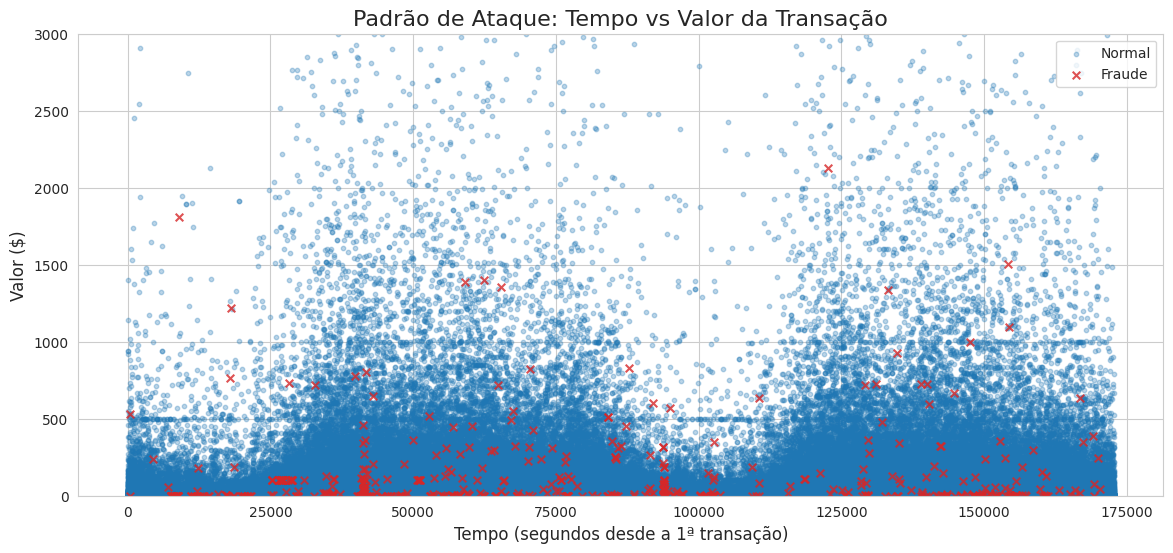

In [12]:
plt.figure(figsize=(14, 6))

# Plotar Transações Normais
plt.scatter(df[df['Class'] == 0]['Time'], df[df['Class'] == 0]['Amount'],
            c='#1f77b4', alpha=0.3, s=10, label='Normal')

# Plotar Fraudes (maiores para destaque)
plt.scatter(df[df['Class'] == 1]['Time'], df[df['Class'] == 1]['Amount'],
            c='#d62728', alpha=0.8, s=30, label='Fraude', marker='x')

plt.title('Padrão de Ataque: Tempo vs Valor da Transação', fontsize=16)
plt.xlabel('Tempo (segundos desde a 1ª transação)', fontsize=12)
plt.ylabel('Valor ($)', fontsize=12)
plt.legend(loc='upper right')

# Limite no eixo Y para focar onde a maioria das fraudes ocorre (muitas vezes < $2000)
# Se quiser ver outliers extremos de valor normal, comente a linha abaixo
plt.ylim(0, 3000)

plt.show()

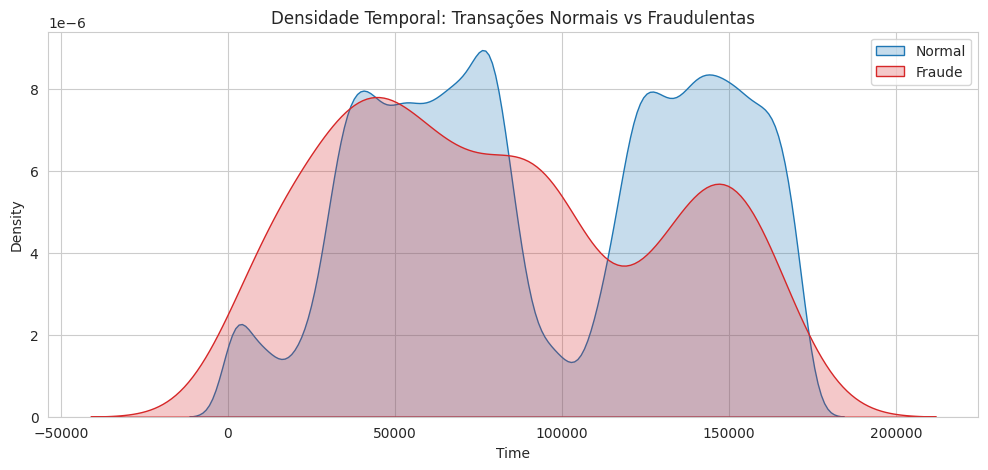

In [13]:
plt.figure(figsize=(12, 5))

# CORREÇÃO AQUI: Trocado 'shade=True' por 'fill=True'
sns.kdeplot(df[df['Class'] == 0]['Time'], label='Normal', fill=True, color='#1f77b4')
sns.kdeplot(df[df['Class'] == 1]['Time'], label='Fraude', fill=True, color='#d62728')

plt.title('Densidade Temporal: Transações Normais vs Fraudulentas')
plt.legend()
plt.show()

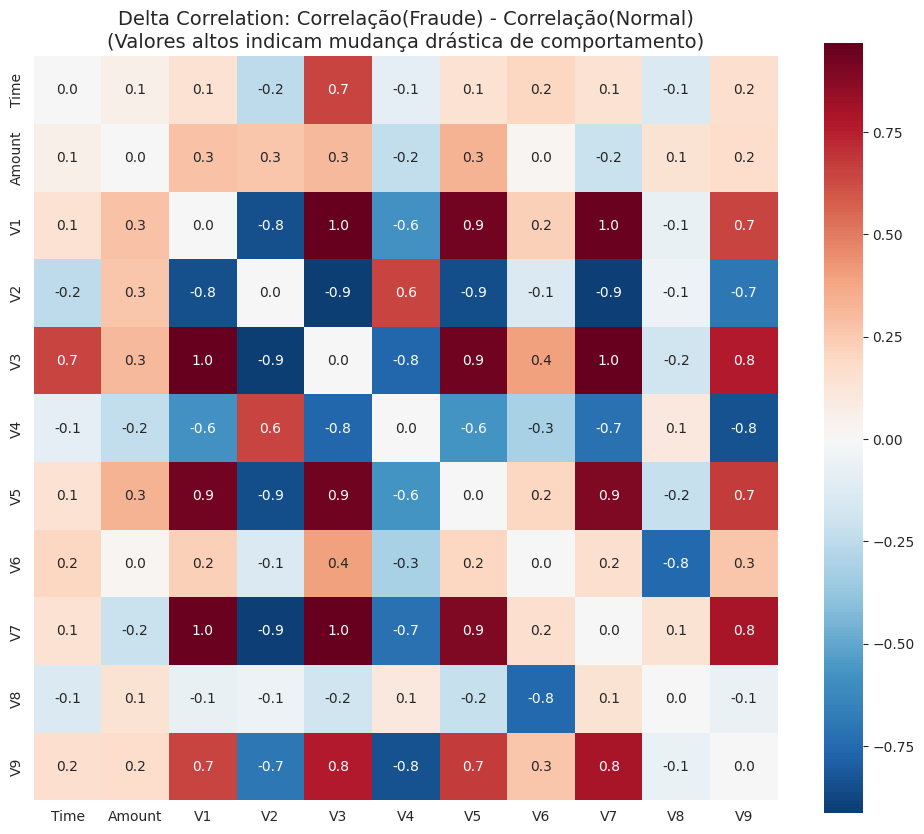

In [14]:
# Calcular matrizes de correlação separadas
corr_normal = df[df['Class'] == 0].corr()
corr_fraude = df[df['Class'] == 1].corr()

# Calcular a diferença absoluta (Mudança na estrutura dos dados)
# Focamos apenas nas colunas V1-V28 e Amount/Time para visualização limpa
cols_to_view = ['Time', 'Amount'] + [f'V{i}' for i in range(1, 10)] # Top 10 V-features para não poluir
diff_corr = corr_fraude.loc[cols_to_view, cols_to_view] - corr_normal.loc[cols_to_view, cols_to_view]

plt.figure(figsize=(12, 10))
sns.heatmap(diff_corr, cmap='RdBu_r', annot=True, fmt=".1f", center=0, square=True)
plt.title('Delta Correlation: Correlação(Fraude) - Correlação(Normal)\n(Valores altos indicam mudança drástica de comportamento)', fontsize=14)
plt.show()

In [ ]:
#Análise Exploratória (EDA)
profile = ProfileReport(df, title="Profiling Report")
profile.to_notebook_iframe()

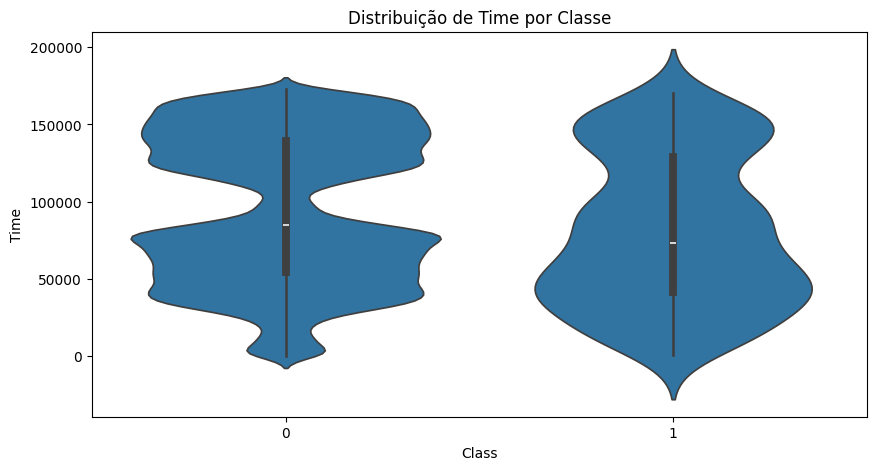

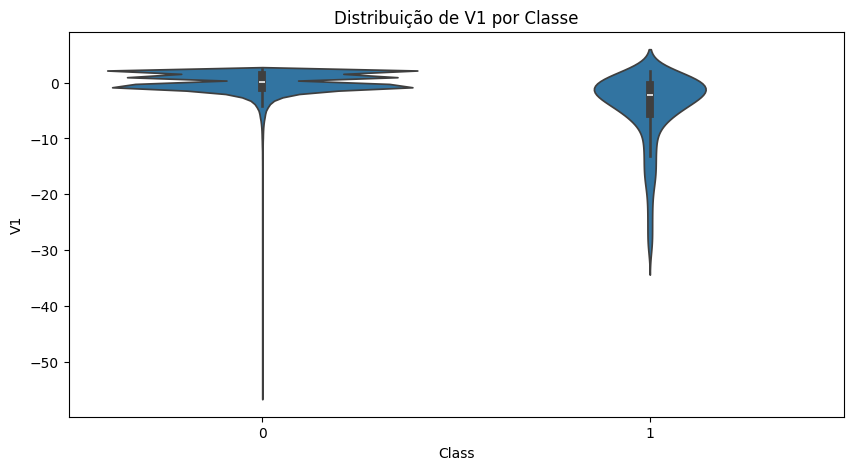

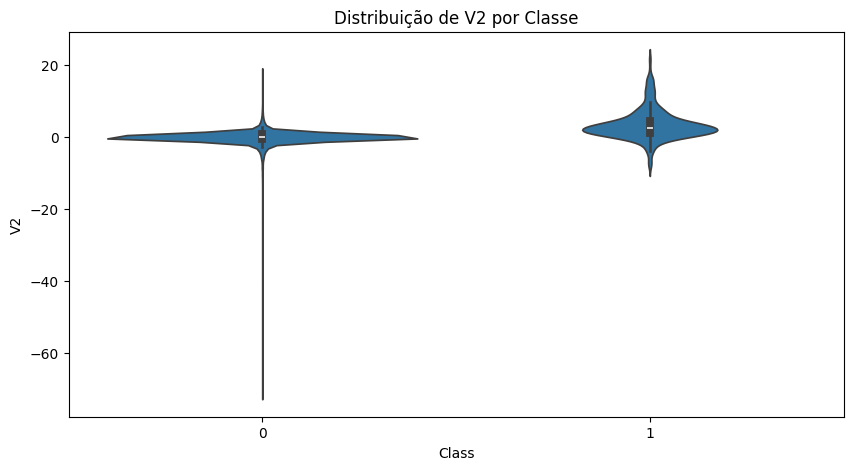

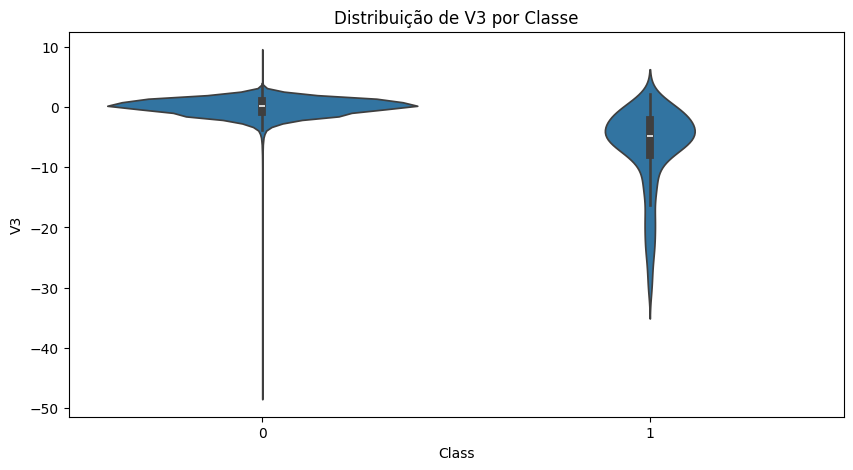

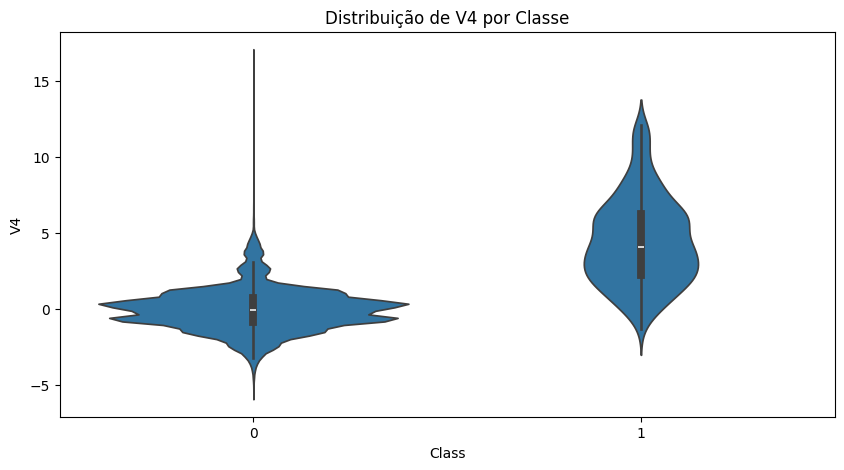

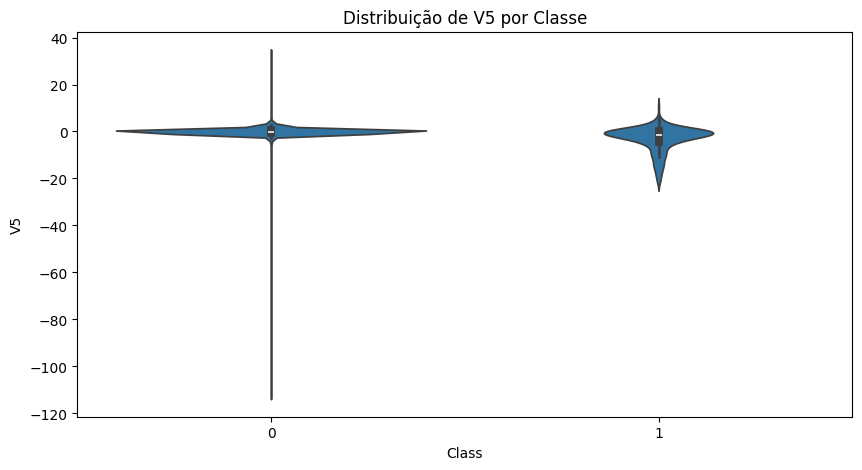

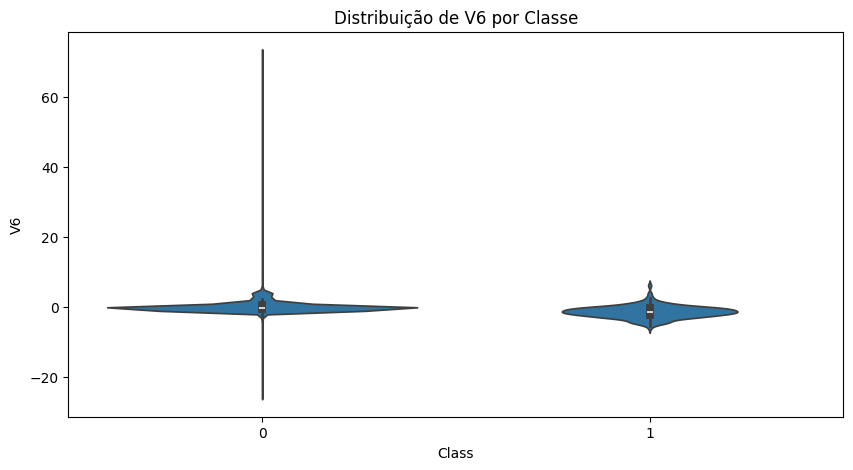

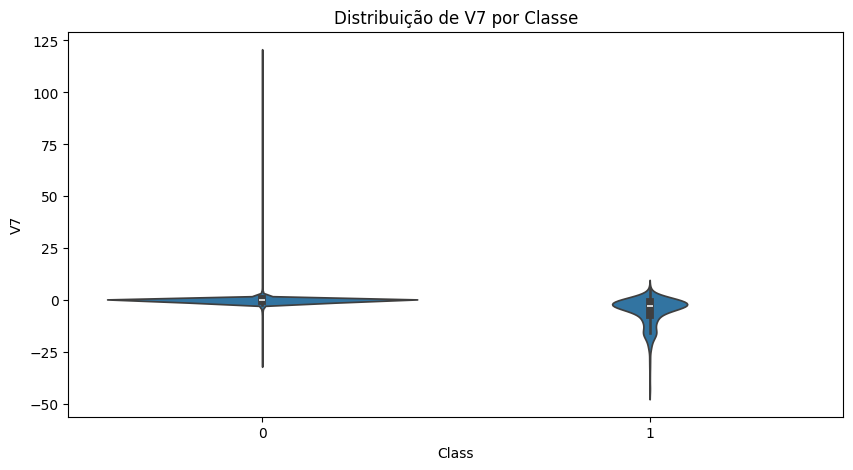

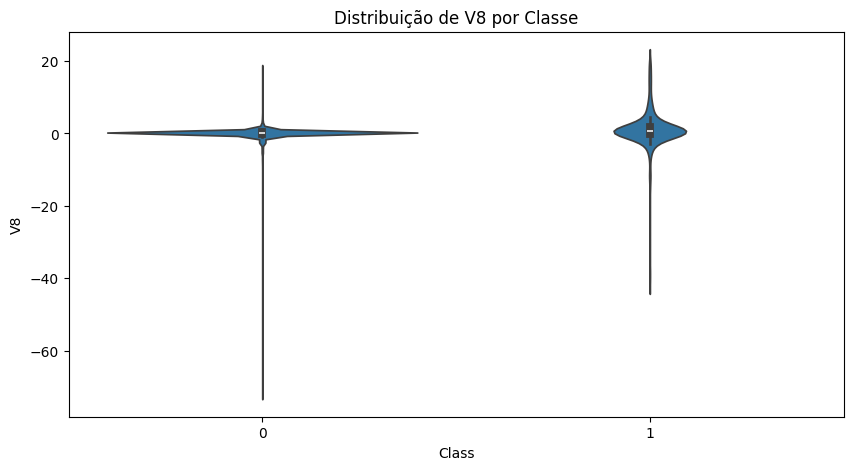

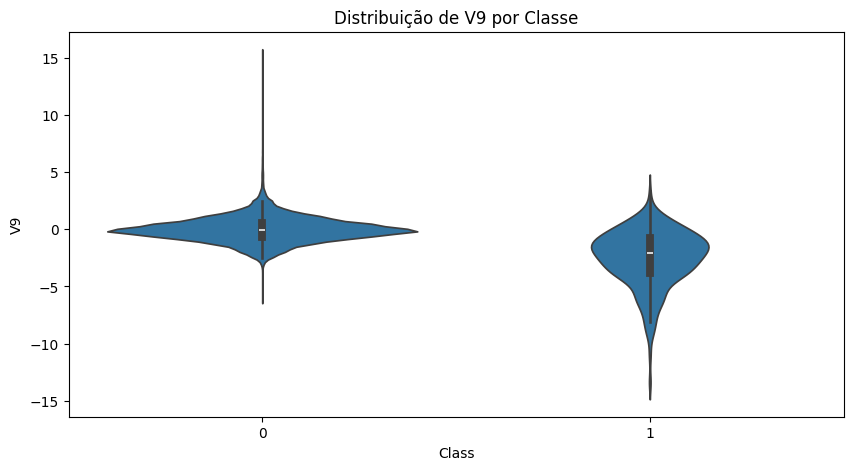

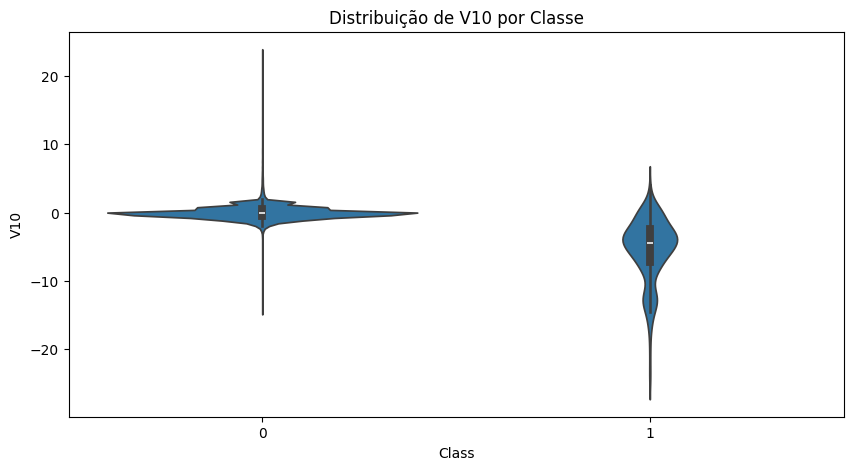

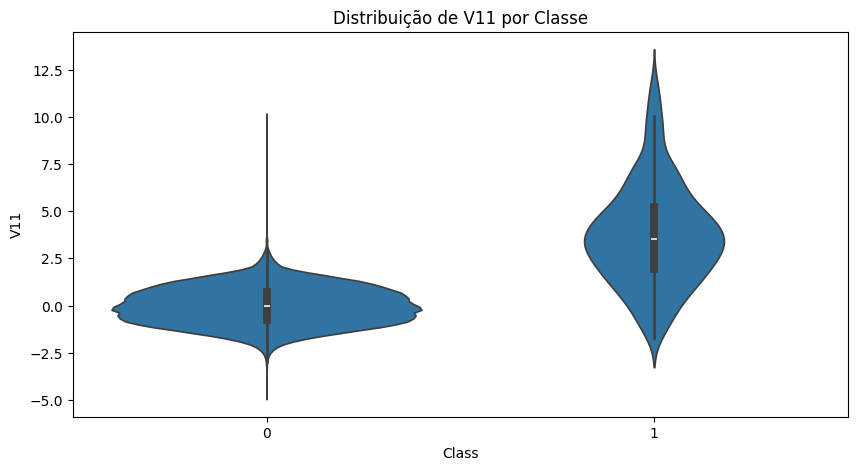

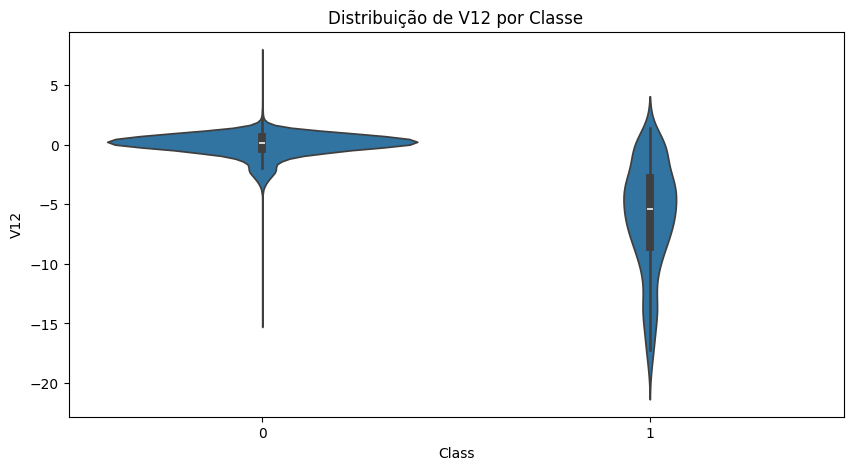

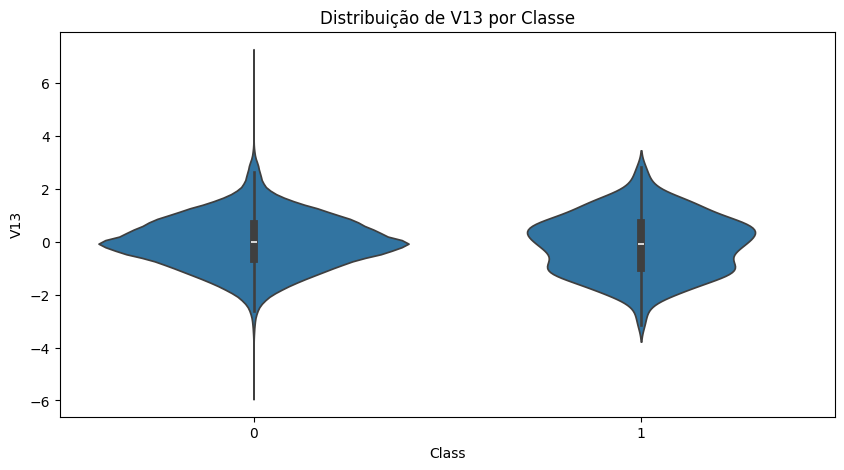

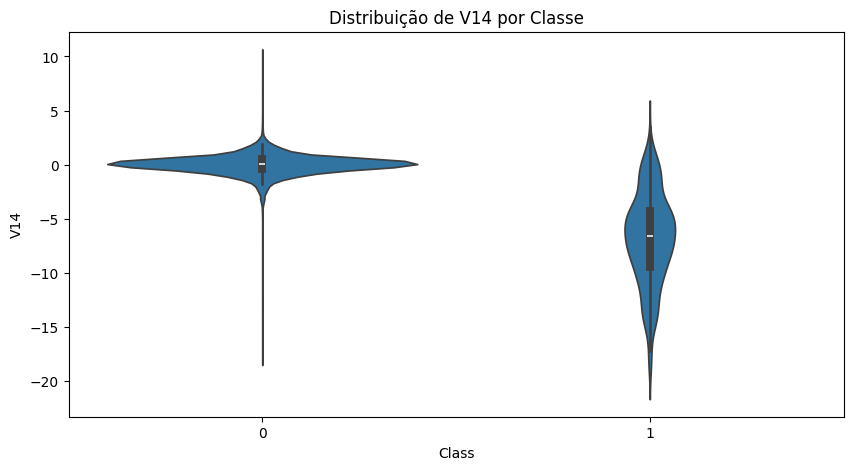

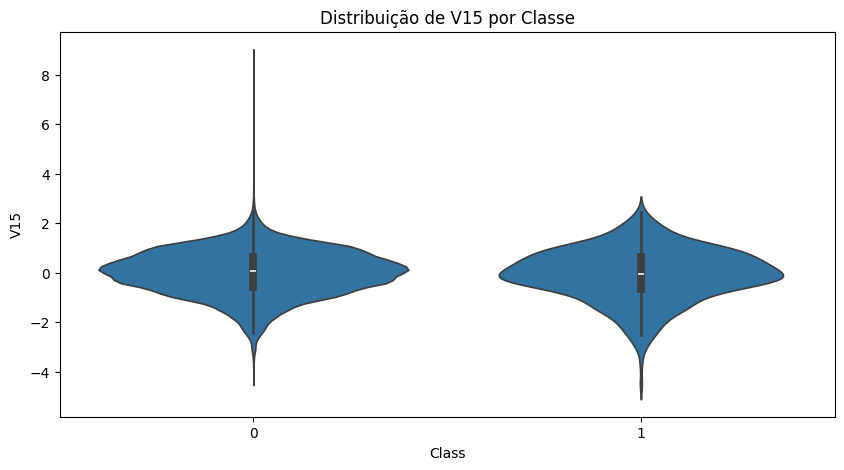

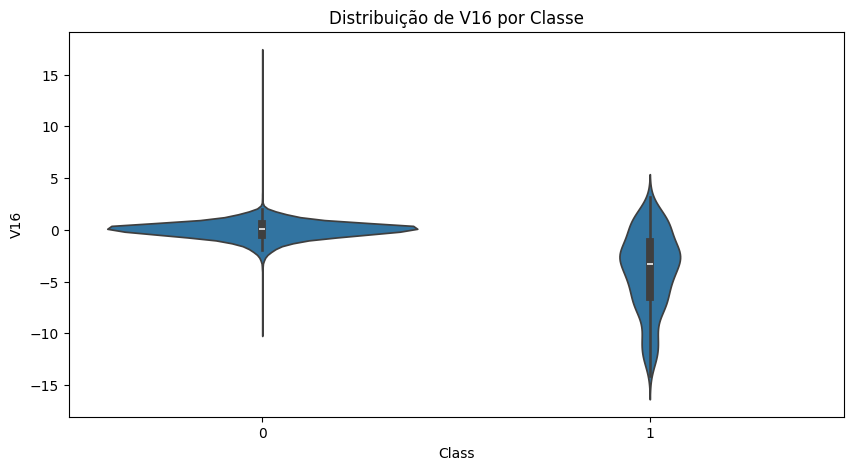

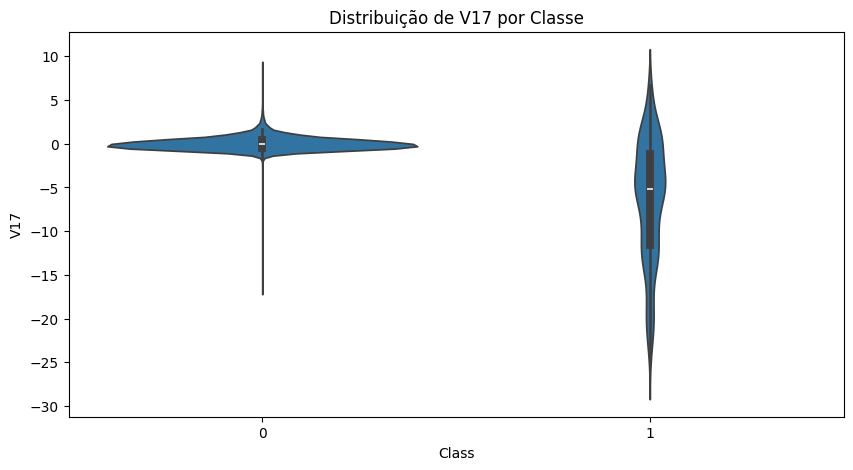

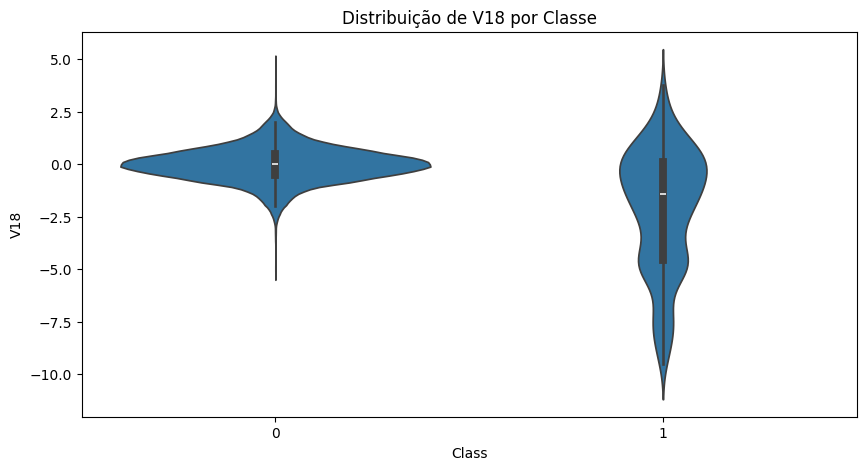

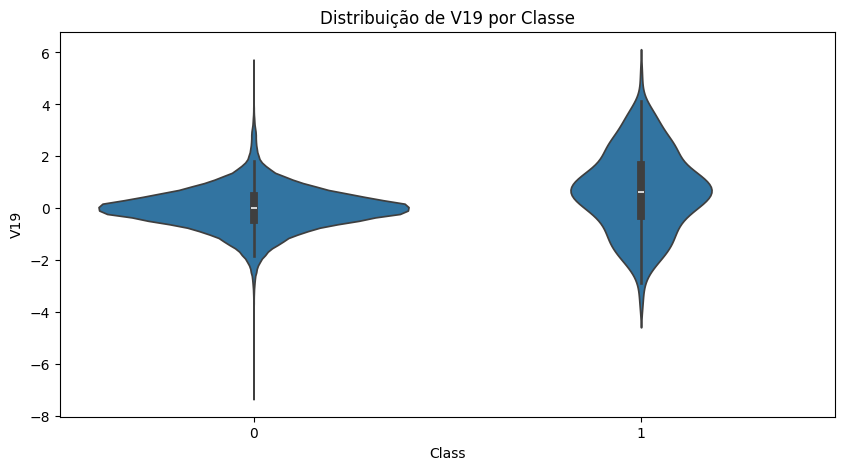

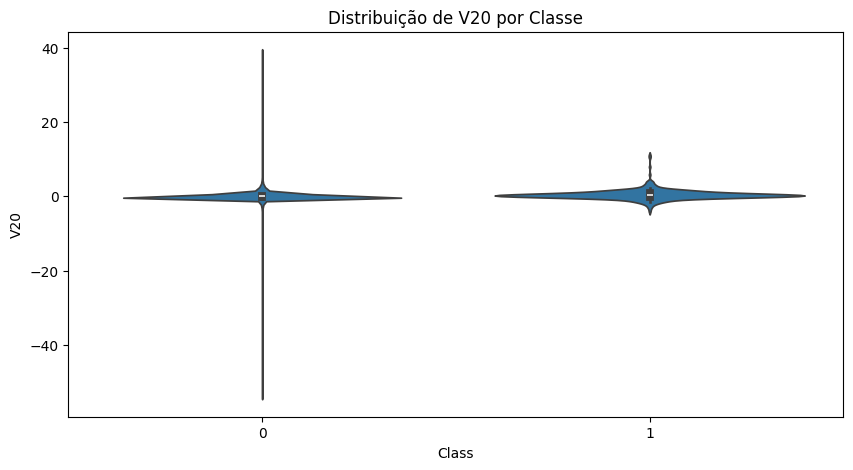

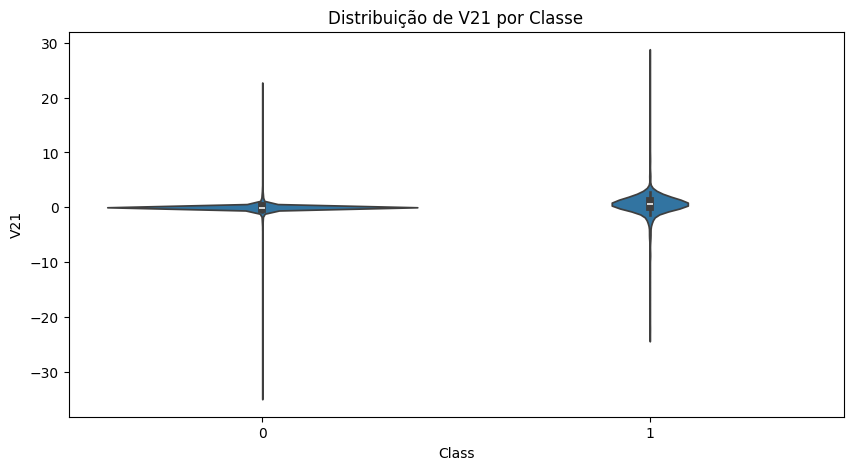

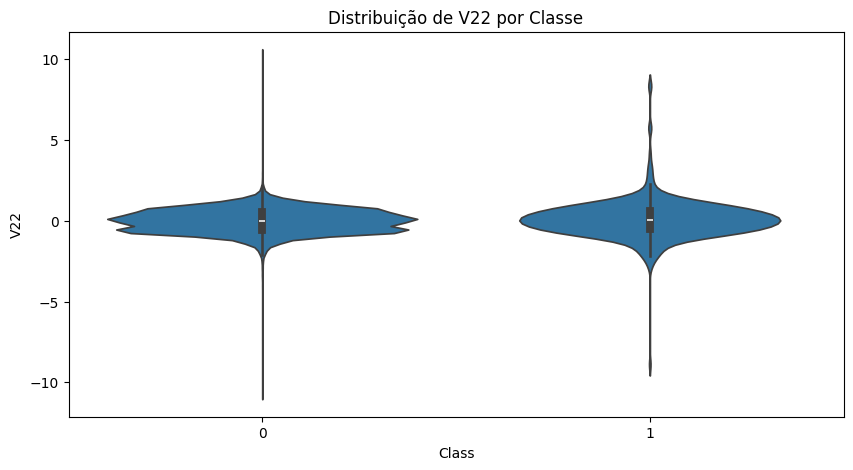

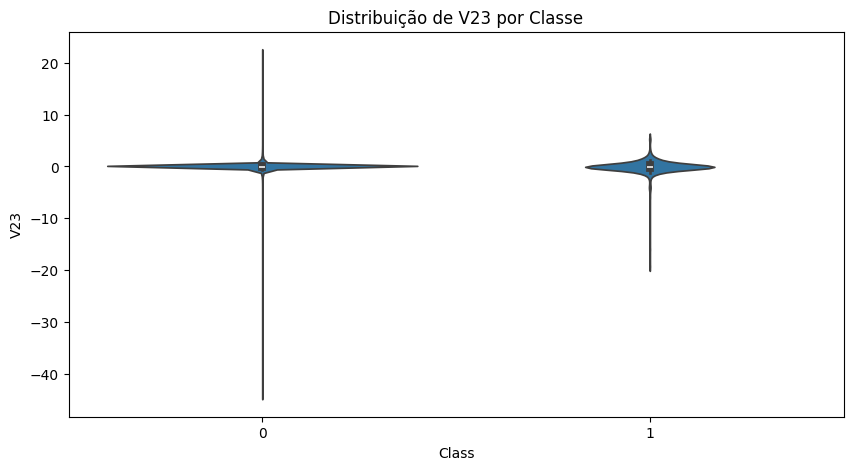

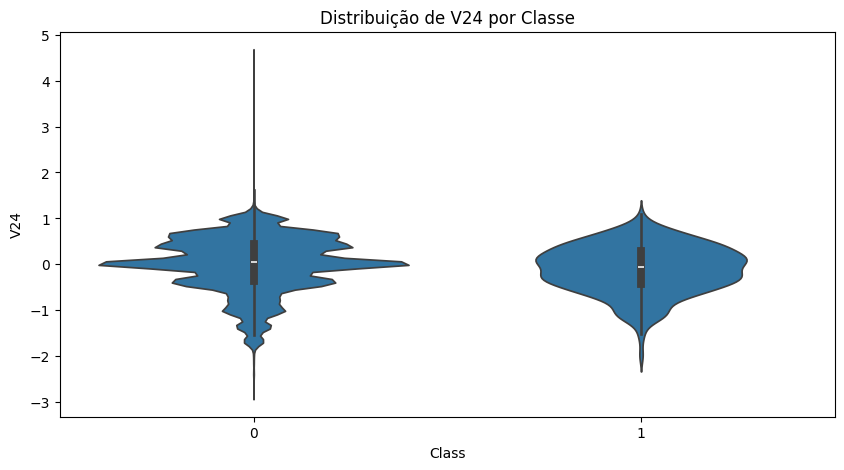

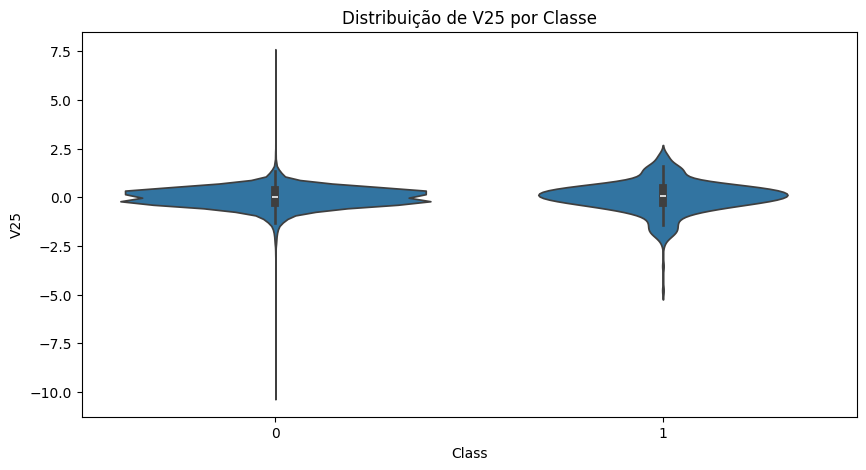

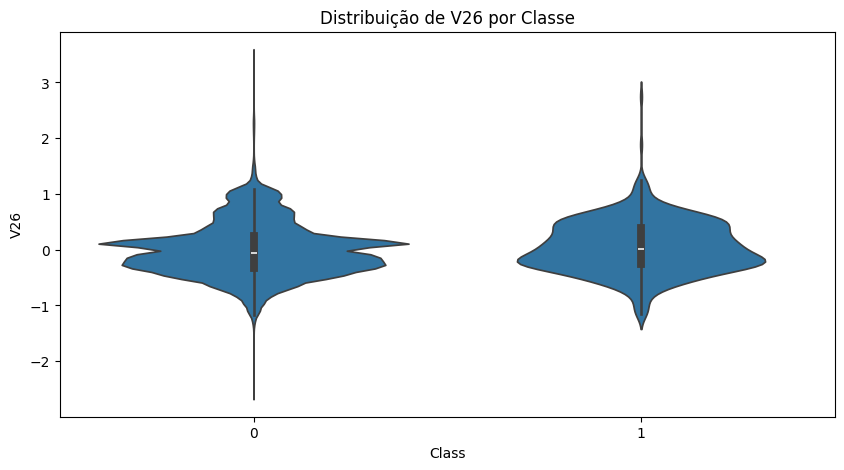

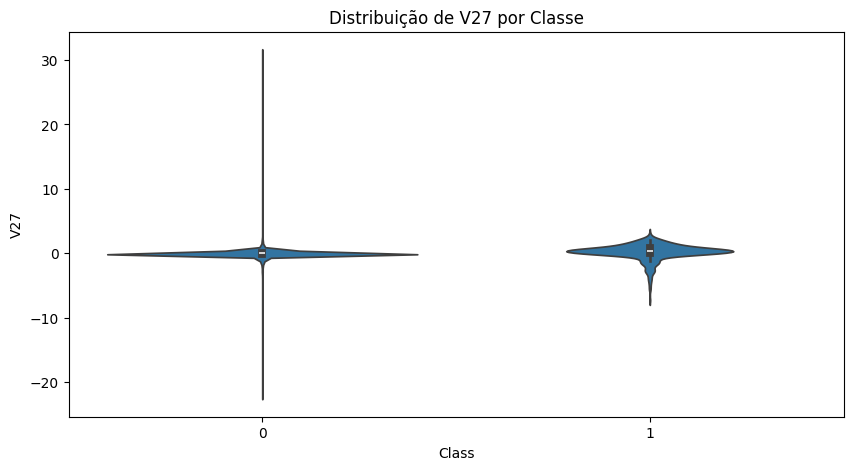

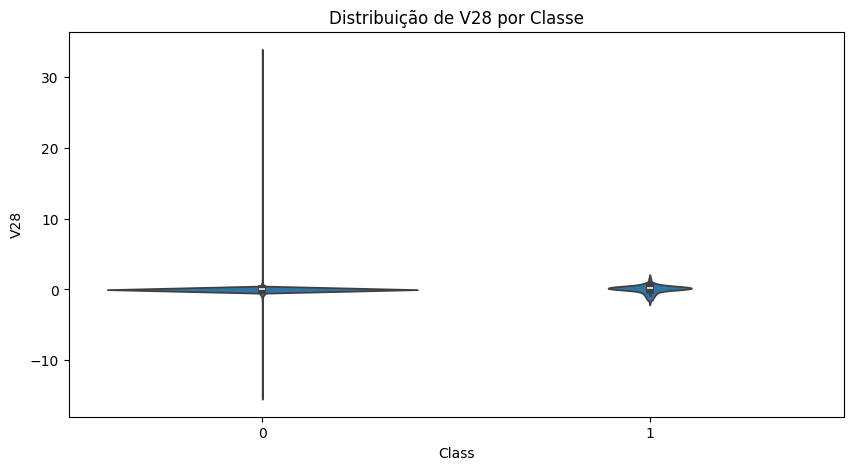

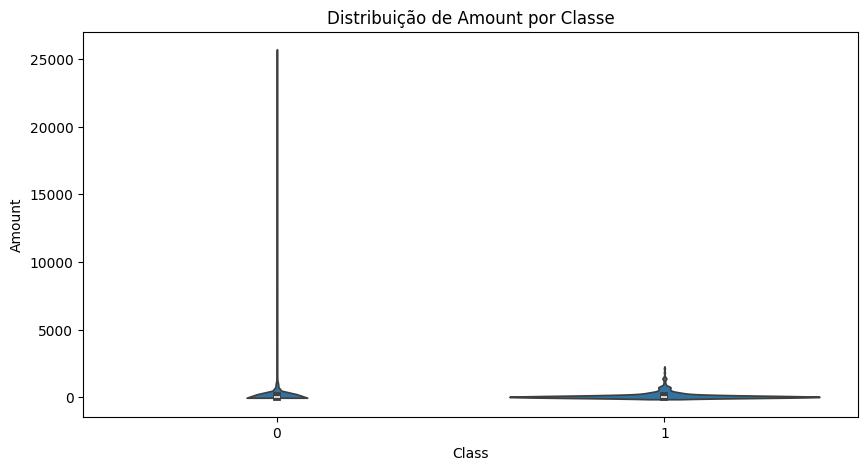

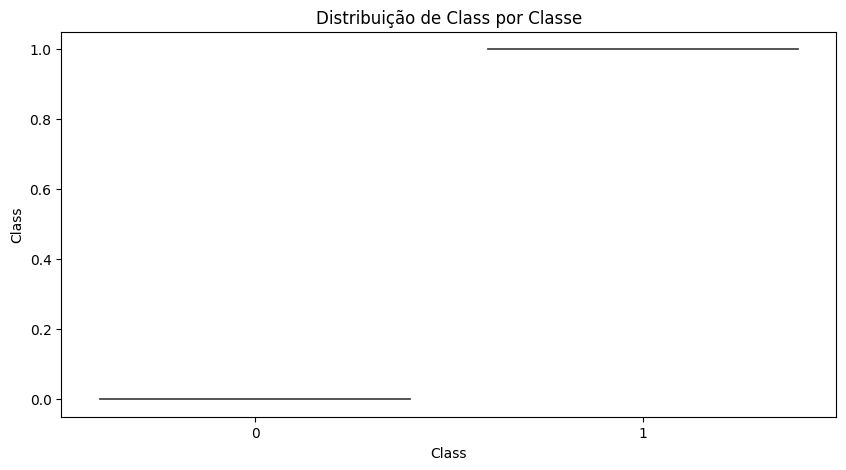

In [ ]:
for column in df:
    plt.figure(figsize=(10, 5))
    sns.violinplot(x='Class', y=column, data=df)
    plt.title(f'Distribuição de {column} por Classe')
    plt.show()

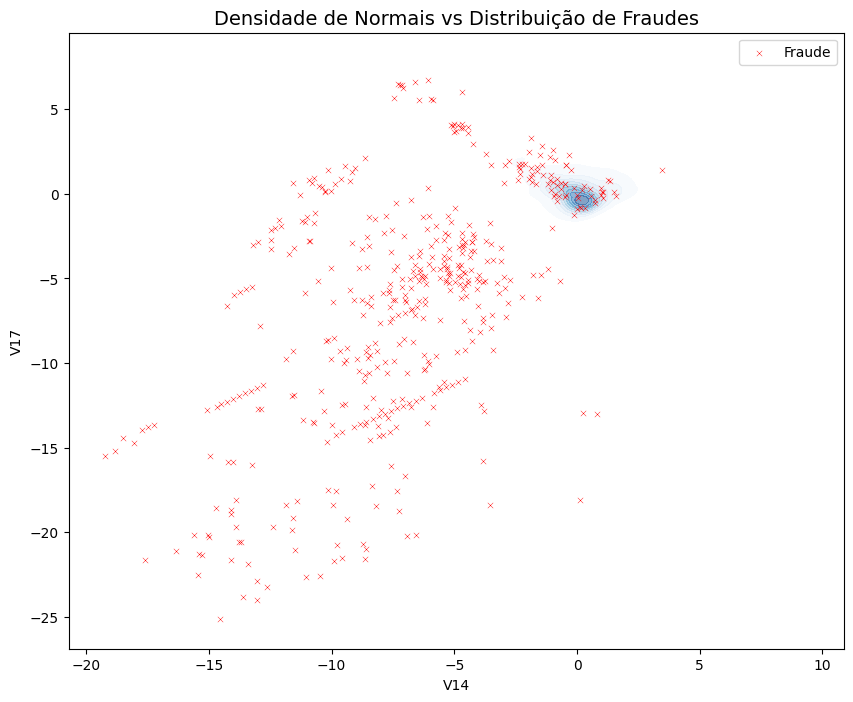

In [ ]:
plt.figure(figsize=(10, 8))

sns.kdeplot(
    data=df[df['Class'] == 0],
    x='V14', y='V17',
    cmap="Blues", fill=True, thresh=0.05, alpha=0.5
)

sns.scatterplot(
    data=df[df['Class'] == 1],
    x='V14', y='V17',
    color='red', s=15, marker='x', label='Fraude'
)

plt.title('Densidade de Normais vs Distribuição de Fraudes', fontsize=14)
plt.legend()
plt.show()

In [15]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [16]:
#Pré-processamento
#----------------#
#Tratamento de Nulos e Duplicatas
print(f"Tamanho com duplicata: {df.shape[0]}")
df.drop_duplicates(inplace=True)
print(f"Tamanho sem duplicata: {df.shape[0]}")

print(f"Número de nulos: {df.isnull().sum().sum()}")

#Scaling e Encoding
##V1 até V28 já passaram por transformação de PCA, precisa normalizar só Time e Ammount
#TODO: Acho que é bom colocar depois no relatório sobre PCA
#Não pode fazer isso antes do split, fica para depois

Tamanho com duplicata: 284807
Tamanho sem duplicata: 283726
Número de nulos: 0


In [17]:
df_normals = df[df['Class'] == 0]
df_frauds = df[df['Class'] == 1]

train_normals, temp_normals = train_test_split(df_normals, test_size=0.3, random_state=RANDOM_STATE)

val_normals, test_normals = train_test_split(temp_normals, test_size=0.5, random_state=RANDOM_STATE)
val_frauds, test_frauds = train_test_split(df_frauds, test_size=0.5, random_state=RANDOM_STATE)

df_train = train_normals.copy()
df_val = pd.concat([val_normals, val_frauds]).sample(frac=1, random_state=RANDOM_STATE)
df_test = pd.concat([test_normals, test_frauds]).sample(frac=1, random_state=RANDOM_STATE)

X_train = df_train.drop('Class', axis=1)
y_train = df_train['Class']

X_val = df_val.drop('Class', axis=1)
y_val = df_val['Class']

X_test = df_test.drop('Class', axis=1)
y_test = df_test['Class']

print(f"Amostras de treino: {X_train.shape[0]}")
print(f"Amostra de teste: {X_test.shape[0]}")
print(f"Amostra de validação: {X_val.shape[0]}")

print(f"Fraudes no treino: {y_train.sum()}")
print(f"Fraudes no teste: {y_test.sum()}")
print(f"Fraudes na validação: {y_val.sum()}")

Amostras de treino: 198277
Amostra de teste: 42725
Amostra de validação: 42724
Fraudes no treino: 0
Fraudes no teste: 237
Fraudes na validação: 236


In [18]:
#Scaling
scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [ ]:
#Conjunto para o t-SNE
X_tsne_fraude = X_val[y_val == 1]

X_tsne_normal = X_train
X_tsne_normal = X_tsne_normal.sample(n=20000, random_state=RANDOM_STATE)

X_tsne = pd.concat([X_tsne_fraude, X_tsne_normal])
y_tsne = np.concatenate([
    np.ones(len(X_tsne_fraude)),
    np.zeros(len(X_tsne_normal))
])

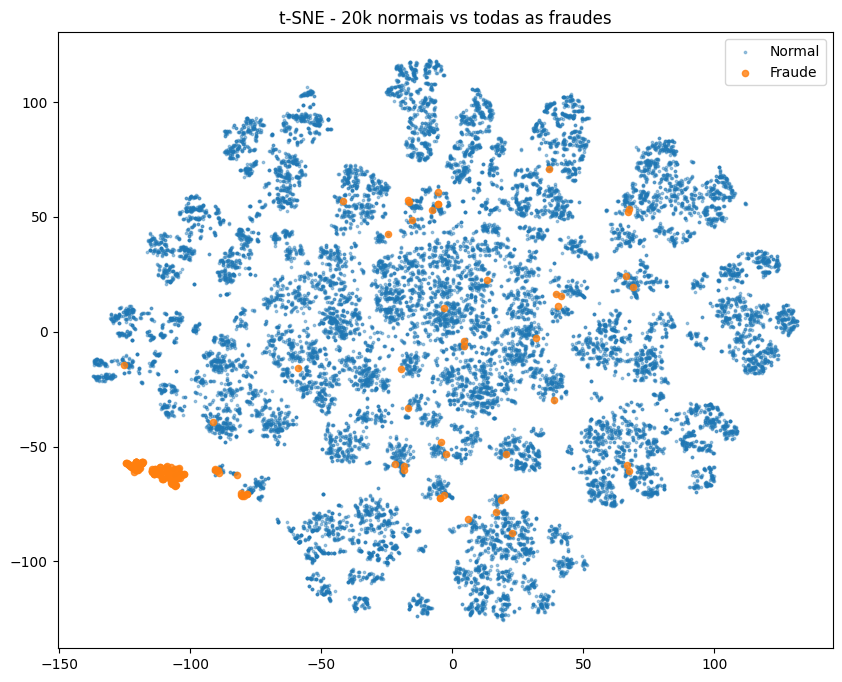

In [ ]:
#t-SNE
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='pca',
    max_iter=1500,
    random_state=RANDOM_STATE
)

X_tsne_embedded = tsne.fit_transform(X_tsne)
plt.figure(figsize=(10, 8))

#Normais
plt.scatter(
    X_tsne_embedded[y_tsne == 0, 0],
    X_tsne_embedded[y_tsne == 0, 1],
    s=3, alpha=0.4, label="Normal"
)

#Fraude
plt.scatter(
    X_tsne_embedded[y_tsne == 1, 0],
    X_tsne_embedded[y_tsne == 1, 1],
    s=20, alpha=0.8, label="Fraude"
)

plt.title("t-SNE - 20k normais vs todas as fraudes")
plt.legend()
plt.show()


# **Modelagem Clássica**

### Modelos com Feature selection

In [19]:
#Feature Selection (Feature Engineering)
#Não da para usar o conjunto de treino porque só tem normais lá
rf_selector = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_selector.fit(X_val, y_val)

importances = rf_selector.feature_importances_
feature_names = X_val.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

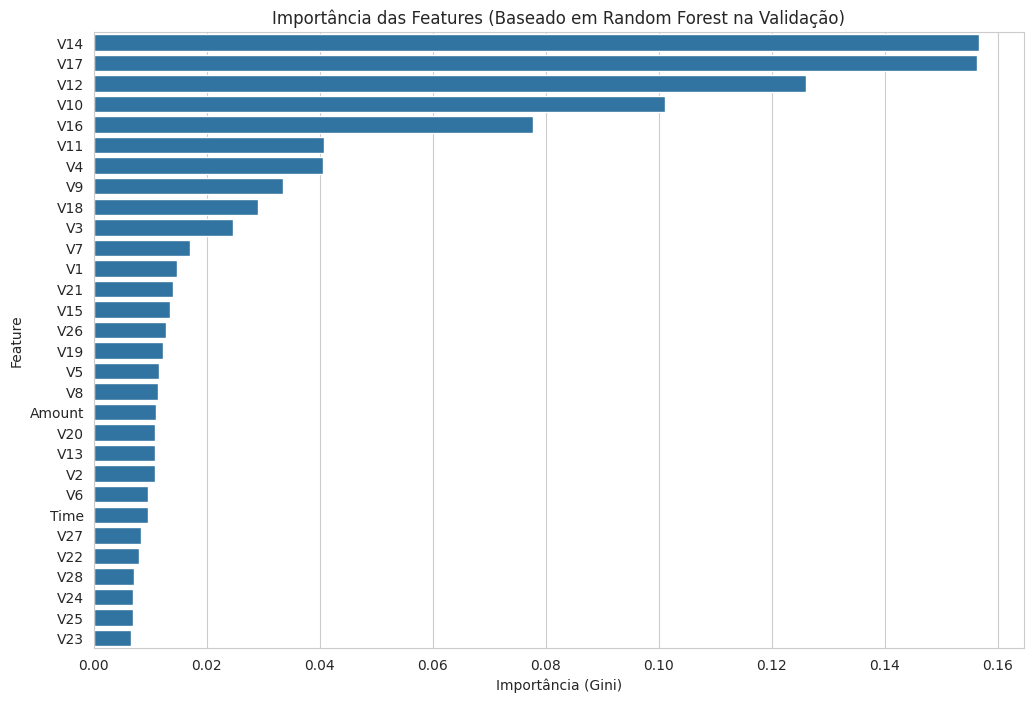

In [20]:
#Grafico com importância das features usando random forest
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Importância das Features (Baseado em Random Forest na Validação)')
plt.xlabel('Importância (Gini)')
plt.ylabel('Feature')
plt.show()

In [21]:
threshold = 0.01
low_importance_features = feature_importance_df[feature_importance_df['Importance'] < threshold]['Feature'].tolist()

print(f"Features com importância abaixo de {threshold}: {len(low_importance_features)}")
print(f"Features menos importantes: {low_importance_features}")

Features com importância abaixo de 0.01: 8
Features menos importantes: ['V6', 'Time', 'V27', 'V22', 'V28', 'V24', 'V25', 'V23']


In [22]:
#Backup dos originais
X_train_original = X_train.copy()
X_val_original = X_val.copy()
X_test_original = X_test.copy()

#Remoção de features menos importantes
cols_to_keep = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature'].tolist()
X_train = X_train[cols_to_keep]
X_val = X_val[cols_to_keep]
X_test = X_test[cols_to_keep]
print(f"Novas dimensões do X_train: {X_train.shape}")

Novas dimensões do X_train: (198277, 22)


### Modelos sem feature selection

In [23]:
#Isolation Forest com todas as features
#Isolation Forest (Probabilístico)
param_grid_if = {
    'n_estimators': [200, 500],
    'max_samples': [128, 256, 512],
    'max_features': [0.6, 0.8, 1.0],
    'bootstrap': [False, True],
}



best_model_if = None
best_score_if = -1
best_params_if = {}

for params in ParameterGrid(param_grid_if):
    model = IsolationForest(
        n_estimators=params['n_estimators'],
        max_samples=params['max_samples'],
        max_features=params['max_features'],
        bootstrap=params['bootstrap'],
        contamination='auto',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    model.fit(X_train_original)

    scores_val = -model.decision_function(X_val_original) # Inverte sinal: maior = mais anômalo
    score = average_precision_score(y_val, scores_val)

    if score > best_score_if:
        best_score_if = score
        best_params_if = params
        best_model_if = model
iso_forest_nfs = best_model_if

In [24]:
print("Melhores hiperparâmetros IF:", best_params_if)
print("Best AP (val):", best_score_if)
print("Baseline:", y_val.mean())

Melhores hiperparâmetros IF: {'bootstrap': True, 'max_features': 0.6, 'max_samples': 512, 'n_estimators': 500}
Best AP (val): 0.3374141387725988
Baseline: 0.005523827356989046


In [31]:
#Descomentar e rodar para recriar o melhor modelo achado no grid search sem precisar rodar ele de novo

# iso_forest_nfs = IsolationForest(
#         n_estimators=500,
#         max_samples=512,
#         max_features=0.6,
#         bootstrap=True,
#         contamination='auto',
#         random_state=RANDOM_STATE,
#         n_jobs=-1
#     )
# iso_forest_nfs.fit(X_train_original)

IsolationForest(bootstrap=True, max_features=0.6, max_samples=512,
                n_estimators=500, n_jobs=-1, random_state=42)

In [32]:
scores_val_if_nfs = -iso_forest_nfs.decision_function(X_val_original)

ap_if_nfs = average_precision_score(y_val, scores_val_if_nfs)
roc_if_nfs = roc_auc_score(y_val, scores_val_if_nfs)

print(f"AP (val): {ap_if_nfs:.4f}")
print(f"ROC-AUC (val): {roc_if_nfs:.4f}")

AP (val): 0.3374
ROC-AUC (val): 0.9485


In [33]:
K = 500
top_k_idx = np.argsort(scores_val_if_nfs)[-K:]
recall_at_k = y_val.iloc[top_k_idx].sum() / y_val.sum()
print(f"Recall@{K}: {recall_at_k:.3f}")

Recall@500: 0.627


In [34]:
precision, recall, thresholds = precision_recall_curve(y_val, scores_val_if_nfs)

precision = precision[:-1]
recall = recall[:-1]

valid = precision >= 0.6
best_idx_if_nfs = np.argmax(recall[valid])
best_threshold_if_nfs = thresholds[valid][best_idx_if_nfs]

print("Threshold escolhido:", best_threshold_if_nfs)
print("Precision:", precision[valid][best_idx_if_nfs])
print("Recall:", recall[valid][best_idx_if_nfs])

Threshold escolhido: 0.17902378975573074
Precision: 0.6
Recall: 0.24152542372881355


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     42488
      Fraude       0.60      0.24      0.34       236

    accuracy                           0.99     42724
   macro avg       0.80      0.62      0.67     42724
weighted avg       0.99      0.99      0.99     42724



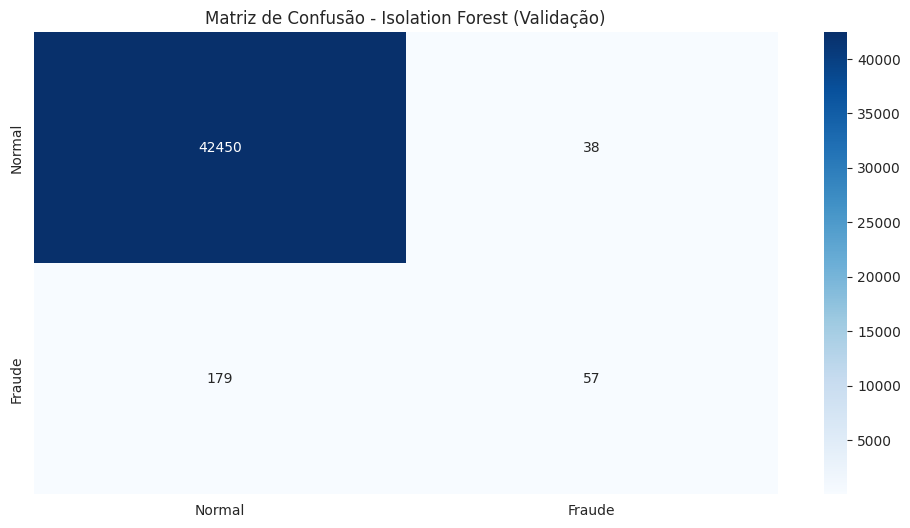

In [35]:
y_pred_if_nfs = (scores_val_if_nfs >= best_threshold_if_nfs).astype(int)

print(classification_report(
    y_val, y_pred_if_nfs, target_names=['Normal', 'Fraude']
))

cm = confusion_matrix(y_val, y_pred_if_nfs)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraude'], yticklabels=['Normal', 'Fraude'])
plt.title('Matriz de Confusão - Isolation Forest (Validação)')
plt.show()

### Modelos com feature selection

#### Isolation Forest

In [ ]:
#Refazendo isolation forest
#Isolation Forest (Probabilístico)
param_grid_if = {
    'n_estimators': [200, 500],
    'max_samples': [128, 256, 512],
    'max_features': [0.6, 0.8, 1.0],
    'bootstrap': [False, True],
}



best_model_if = None
best_score_if = -1
best_params_if = {}

for params in ParameterGrid(param_grid_if):
    model = IsolationForest(
        n_estimators=params['n_estimators'],
        max_samples=params['max_samples'],
        max_features=params['max_features'],
        bootstrap=params['bootstrap'],
        contamination='auto',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    model.fit(X_train)

    scores_val = -model.decision_function(X_val) # Inverte sinal: maior = mais anômalo
    score = average_precision_score(y_val, scores_val)

    if score > best_score_if:
        best_score_if = score
        best_params_if = params
        best_model_if = model
iso_forest = best_model_if

In [ ]:
print("Melhores hiperparâmetros IF:", best_params_if)
print("Best AP (val):", best_score_if)
print("Baseline:", y_val.mean())

Melhores hiperparâmetros IF: {'bootstrap': True, 'max_features': 0.8, 'max_samples': 512, 'n_estimators': 200}
Best AP (val): 0.42126004235338654
Baseline: 0.005523827356989046


In [36]:
#Descomentar e rodar para recriar o melhor modelo achado no grid search sem precisar rodar ele de novo

iso_forest = IsolationForest(
        n_estimators=200,
        max_samples=512,
        max_features=0.8,
        bootstrap=True,
        contamination='auto',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
iso_forest.fit(X_train)

IsolationForest(bootstrap=True, max_features=0.8, max_samples=512,
                n_estimators=200, n_jobs=-1, random_state=42)

In [37]:
scores_val_if = -iso_forest.decision_function(X_val)

ap_if = average_precision_score(y_val, scores_val_if)
roc_if = roc_auc_score(y_val, scores_val_if)

print(f"AP (val): {ap_if:.4f}")
print(f"ROC-AUC (val): {roc_if:.4f}")

AP (val): 0.4213
ROC-AUC (val): 0.9561


In [38]:
K = 500
top_k_idx = np.argsort(scores_val_if)[-K:]
recall_at_k = y_val.iloc[top_k_idx].sum() / y_val.sum()
print(f"Recall@{K}: {recall_at_k:.3f}")

Recall@500: 0.708


In [39]:
precision, recall, thresholds = precision_recall_curve(y_val, scores_val_if)

precision = precision[:-1]
recall = recall[:-1]

valid = precision >= 0.6
best_idx_if = np.argmax(recall[valid])
best_threshold_if = thresholds[valid][best_idx_if]

print("Threshold escolhido:", best_threshold_if)
print("Precision:", precision[valid][best_idx_if])
print("Recall:", recall[valid][best_idx_if])

Threshold escolhido: 0.16452341924221148
Precision: 0.6
Recall: 0.3559322033898305


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     42488
      Fraude       0.60      0.36      0.45       236

    accuracy                           1.00     42724
   macro avg       0.80      0.68      0.72     42724
weighted avg       0.99      1.00      0.99     42724



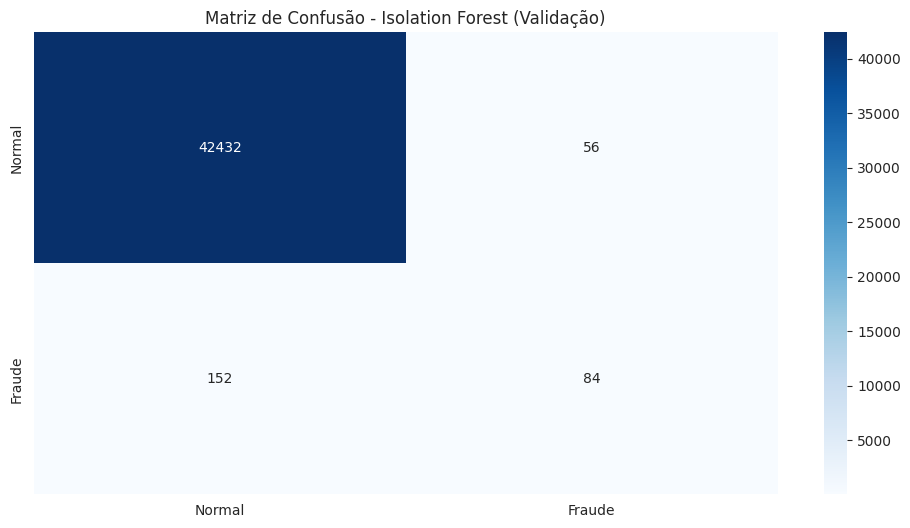

In [40]:
y_pred_if = (scores_val_if >= best_threshold_if).astype(int)

print(classification_report(
    y_val, y_pred_if, target_names=['Normal', 'Fraude']
))

cm = confusion_matrix(y_val, y_pred_if)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraude'], yticklabels=['Normal', 'Fraude'])
plt.title('Matriz de Confusão - Isolation Forest (Validação)')
plt.show()

####LOF

In [ ]:
#LOF
param_grid_lof = {
    'n_neighbors': [20, 50, 100],
    'metric': ['euclidean', 'minkowski'],
    'contamination': ['auto']
}

best_lof_model = None
best_lof_score = -1
best_lof_params = {}

for params in ParameterGrid(param_grid_lof):
    model = LocalOutlierFactor(
        n_neighbors=params['n_neighbors'],
        metric=params['metric'],
        contamination='auto',
        novelty=True,
        n_jobs=-1
    )
    model.fit(X_train)

    scores_val = -model.decision_function(X_val)
    score = average_precision_score(y_val, scores_val)

    if score > best_lof_score:
        best_lof_score = score
        best_lof_model = model
        best_lof_params = params
lof = best_lof_model

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist

In [ ]:
print("Melhores hiperparâmetros LOF:", best_lof_params)
print("Best AP (val):", best_lof_score)
print("Baseline:", y_val.mean())

Melhores hiperparâmetros LOF: {'contamination': 'auto', 'metric': 'euclidean', 'n_neighbors': 100}
Best AP (val): 0.545859782411129
Baseline: 0.005523827356989046


In [42]:
#Descomentar e rodar para recriar o melhor modelo achado no grid search sem precisar rodar ele de novo

lof = LocalOutlierFactor(
        n_neighbors=100,
        metric='euclidean',
        contamination='auto',
        novelty=True,
        n_jobs=-1
    )
lof.fit(X_train)

LocalOutlierFactor(metric='euclidean', n_jobs=-1, n_neighbors=100, novelty=True)

In [43]:
scores_val = -lof.decision_function(X_val)

print("AP (val):", average_precision_score(y_val, scores_val))
print("ROC-AUC (val):", roc_auc_score(y_val, scores_val))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


AP (val): 0.545859782411129
ROC-AUC (val): 0.9407753016604489


In [44]:
K = 500
top_k_idx = np.argsort(scores_val)[-K:]
recall_at_k = y_val.iloc[top_k_idx].sum() / y_val.sum()
print(f"Recall@{K}: {recall_at_k:.3f}")

Recall@500: 0.780


In [45]:
precision, recall, thresholds = precision_recall_curve(y_val, scores_val)

precision = precision[:-1]
recall = recall[:-1]

valid = precision >= 0.6
best_idx = np.argmax(recall[valid])
best_threshold = thresholds[valid][best_idx]

print("Threshold escolhido:", best_threshold)
print("Precision:", precision[valid][best_idx])
print("Recall:", recall[valid][best_idx])

Threshold escolhido: 1.1737304532723822
Precision: 0.6014234875444839
Recall: 0.7161016949152542


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     42488
      Fraude       0.60      0.72      0.65       236

    accuracy                           1.00     42724
   macro avg       0.80      0.86      0.83     42724
weighted avg       1.00      1.00      1.00     42724



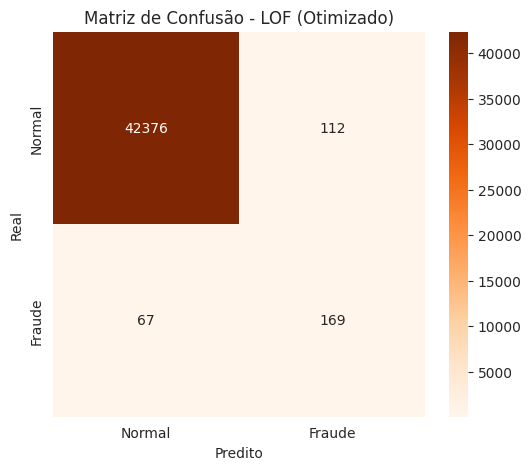

In [46]:
y_pred_val = (scores_val >= best_threshold).astype(int)
print(classification_report(y_val, y_pred_val, target_names=["Normal", "Fraude"]))
cm_lof = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lof, annot=True, fmt='d', cmap='Oranges', # Usei cor diferente para distinguir
            xticklabels=['Normal', 'Fraude'],
            yticklabels=['Normal', 'Fraude'])
plt.title('Matriz de Confusão - LOF (Otimizado)')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.show()

# **Deep Learning & Avançado**

## Preparação dos Dados

In [47]:
# treinando apenas com dados normais para que o modelo aprenda a "reconstruir a normalidade"
# tudo o que for diferente (fraude) terá alto erro de reconstrução
X_train_normal = X_train[y_train == 0]
X_val_normal = X_val[y_val == 0]

print(f"Treinando apenas com transações normais: {X_train_normal.shape}")

Treinando apenas com transações normais: (198277, 22)


## Arquitetura Autoencoder

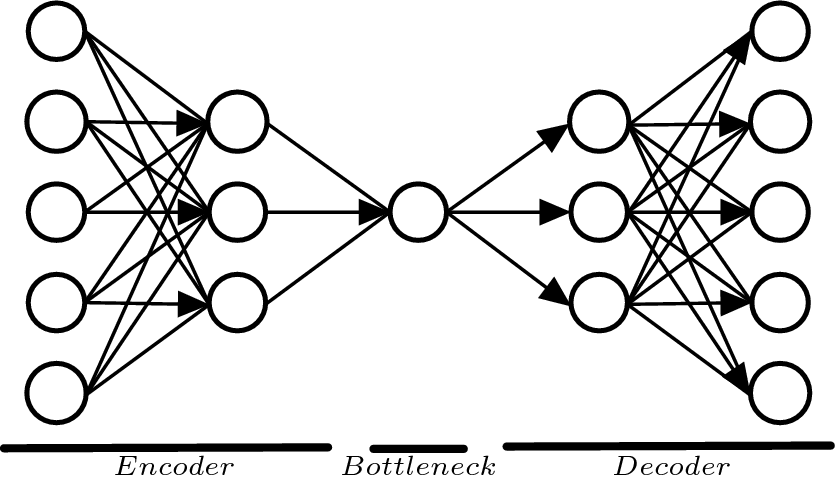

In [50]:
def build_autoencoder(input_dim, bottleneck_dim):
    model = Sequential([
        Input(shape=(input_dim,)),

        # Encoder
        Dense(20, activation='relu'),
        Dropout(0.2),

        # Bottleneck (hiperparâmetro tunável)
        Dense(bottleneck_dim, activation='relu'),

        # Decoder
        Dense(20, activation='relu'),
        Dense(input_dim, activation='linear')
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

In [51]:
input_dim = X_train.shape[1]
bottleneck_grid = [4, 8, 10, 16]

best_ap = -1
best_bottleneck = None
best_autoencoder = None

for bottleneck_dim in bottleneck_grid:
    print(f"\nTreinando Autoencoder com bottleneck = {bottleneck_dim}")

    autoencoder = build_autoencoder(input_dim, bottleneck_dim)

    autoencoder.fit(
        X_train_normal, X_train_normal,
        epochs=50,
        batch_size=64,
        shuffle=True,
        validation_data=(X_val, X_val),
        verbose=0,
        callbacks=[
            EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            )
        ]
    )

    # Avaliação na validação (AP)
    X_val_pred = autoencoder.predict(X_val, verbose=0)
    mse_val = np.mean(np.power(X_val - X_val_pred, 2), axis=1)

    ap = average_precision_score(y_val, mse_val)
    print(f"AP (val): {ap:.4f}")

    if ap > best_ap:
        best_ap = ap
        best_bottleneck = bottleneck_dim
        best_autoencoder = autoencoder

autoencoder = best_autoencoder


Treinando Autoencoder com bottleneck = 4
AP (val): 0.7215

Treinando Autoencoder com bottleneck = 8
AP (val): 0.7289

Treinando Autoencoder com bottleneck = 10
AP (val): 0.7251

Treinando Autoencoder com bottleneck = 16
AP (val): 0.7208


In [52]:
print("\n==============================")
print("MELHOR AUTOENCODER")
print(f"Bottleneck: {best_bottleneck}")
print(f"Best AP (val): {best_ap:.4f}")
print("==============================")


MELHOR AUTOENCODER
Bottleneck: 8
Best AP (val): 0.7289


In [ ]:
#Descomentar e rodar para recriar o melhor modelo achado no grid search sem precisar rodar ele de novo

input_dim = X_train.shape[1]
autoencoder = build_autoencoder(input_dim, 8)

history = autoencoder.fit(
        X_train_normal, X_train_normal,
        epochs=50,
        batch_size=64,
        shuffle=True,
        validation_data=(X_val, X_val),
        verbose=0,
        callbacks=[
            EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            )
        ]
    )

In [53]:
autoencoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 20)             │           460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 20)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 22)             │           462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,812 (14.89 KB)

 Trainable params: 1,270 (4.96 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,542 (9.93 KB)

## Treinamento

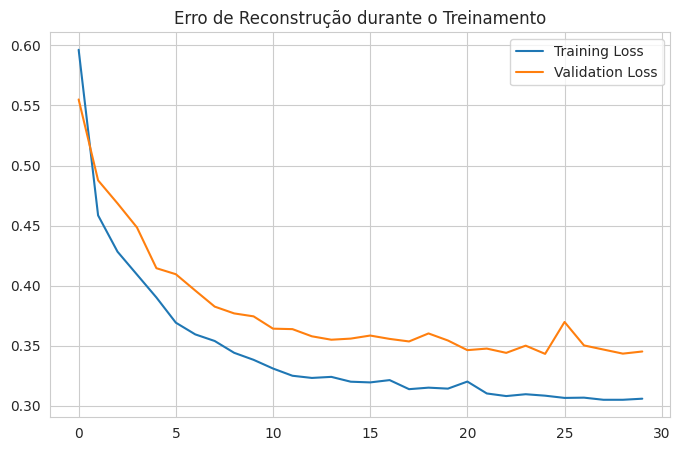

In [54]:
# Visualização das curvas de aprendizado (diagnóstico de overfitting/underfitting)
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Erro de Reconstrução durante o Treinamento')
plt.legend()
plt.show()

## Threshold

In [55]:
# 1. Inferência no conjunto de Validação (que contém fraudes misturadas)
X_val_pred = autoencoder.predict(X_val)

# 2. Calcular o MSE (Score de Anomalia) para cada transação
mse_val = np.mean(np.power(X_val - X_val_pred, 2), axis=1)

1336/1336 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


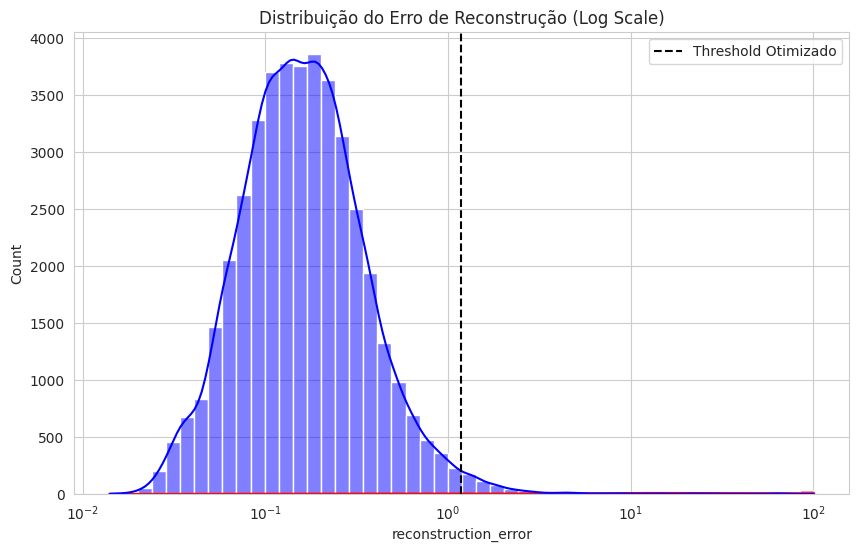

In [57]:
# Gráfico da distribuição com escala LOG (ajuda a ver os outliers extremos)
error_df = pd.DataFrame({'reconstruction_error': mse_val, 'true_class': y_val})
plt.figure(figsize=(10,6))
sns.histplot(data=error_df, x='reconstruction_error', hue='true_class', bins=50, kde=True, palette=['blue', 'red'], log_scale=(True, False))
plt.axvline(best_threshold, color='k', linestyle='--', label='Threshold Otimizado')
plt.title('Distribuição do Erro de Reconstrução (Log Scale)')
plt.legend()
plt.show()

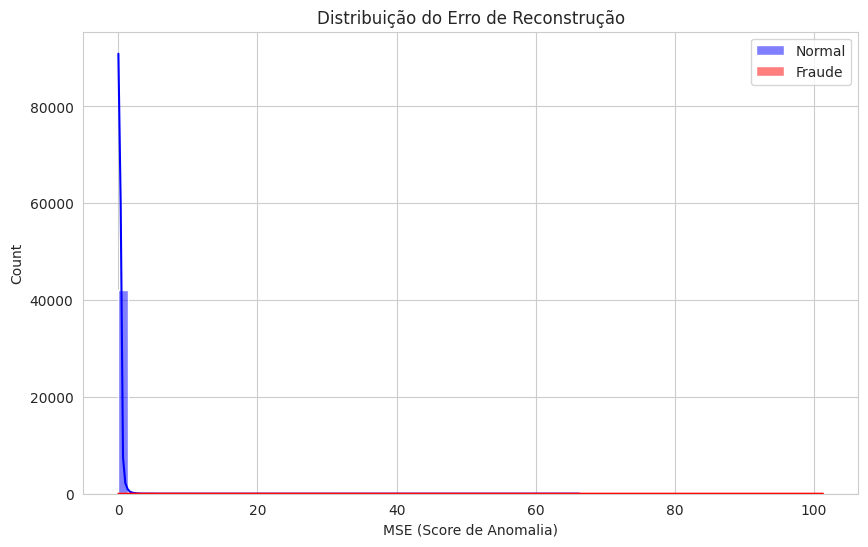

In [58]:
# Visualização da separação entre Normais (azul) e Fraudes (vermelho)
plt.figure(figsize=(10,6))
sns.histplot(error_df[error_df['true_class']==0]['reconstruction_error'], bins=50, kde=True, label='Normal', color='blue')
sns.histplot(error_df[error_df['true_class']==1]['reconstruction_error'], bins=50, kde=True, label='Fraude', color='red')
plt.title('Distribuição do Erro de Reconstrução')
plt.xlabel('MSE (Score de Anomalia)')
plt.legend()
plt.show()

In [59]:
# 3. Otimização do Threshold via F1-Score
# Em vez de chutar um valor, testamos todos os pontos da curva Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_val, mse_val)

f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores) # Tratar divisão por zero

# Escolher o threshold que maximiza o F1 (equilíbrio)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Melhor Threshold encontrado: {best_threshold:.4f}")
print(f"Melhor F1-Score (Validação): {best_f1:.4f}")

Melhor Threshold encontrado: 4.6548
Melhor F1-Score (Validação): 0.7875


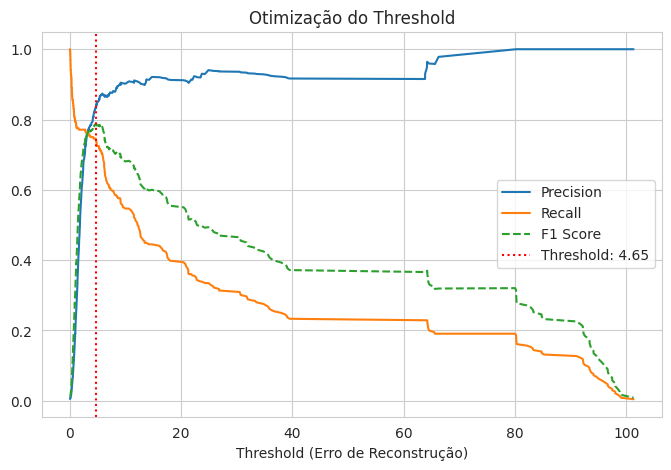

In [60]:
# Gráfico das métricas em função do threshold
plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score', linestyle='--')
plt.axvline(best_threshold, color='red', linestyle='dotted', label=f'Threshold: {best_threshold:.2f}')
plt.xlabel('Threshold (Erro de Reconstrução)')
plt.legend()
plt.title('Otimização do Threshold')
plt.show()

## Análises

In [61]:
# Aplicação do modelo final no conjunto de TESTE (Holdout)
X_test_pred = autoencoder.predict(X_test)
mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Classificação binária usando o threshold otimizado anteriormente
y_pred_test_ae = (mse_test > best_threshold).astype(int)

print("-" * 30)
print("Relatório do Autoencoder (Conjunto de Teste)")
print("-" * 30)
print(classification_report(y_test, y_pred_test_ae, target_names=['Normal', 'Fraude']))

1336/1336 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
------------------------------
Relatório do Autoencoder (Conjunto de Teste)
------------------------------
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     42488
      Fraude       0.87      0.78      0.83       237

    accuracy                           1.00     42725
   macro avg       0.94      0.89      0.91     42725
weighted avg       1.00      1.00      1.00     42725



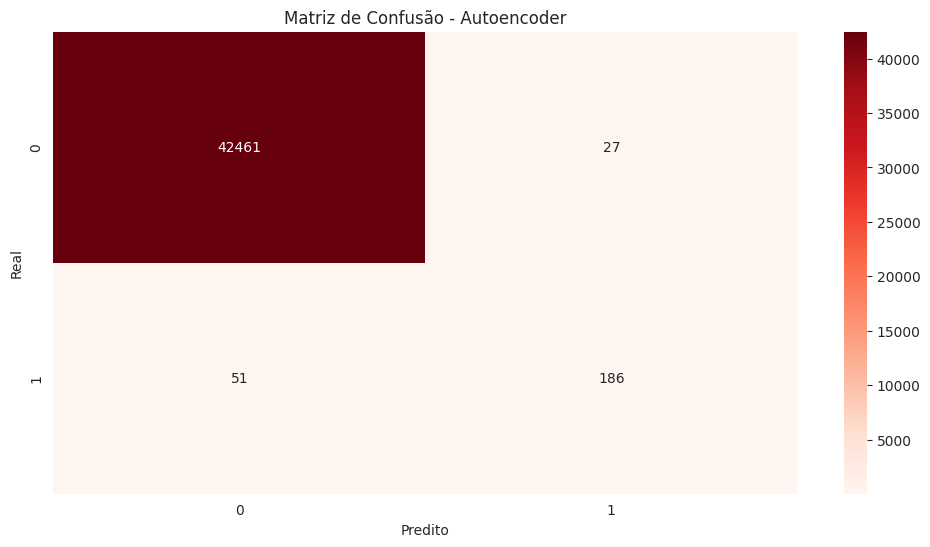

In [62]:
# Matriz de Confusão para ver Falsos Positivos vs Falsos Negativos
cm = confusion_matrix(y_test, y_pred_test_ae)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Matriz de Confusão - Autoencoder')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

In [63]:
# Métrica global independente do threshold
auc_score = roc_auc_score(y_test, mse_test)
print(f"AUC-ROC Score: {auc_score:.4f}")

AUC-ROC Score: 0.9422


In [64]:
# --- Análise de Falhas ---
print("\n--- Investigação: O Autoencoder falha em valores baixos? ---")

# Isolar índices de erros (Falsos Negativos) e acertos (Verdadeiros Positivos)
mask_fn = (y_test == 1) & (y_pred_test_ae == 0)
mask_tp = (y_test == 1) & (y_pred_test_ae == 1)

# Recuperar o valor original da transação ('Amount')
fn_amounts = df.loc[y_test[mask_fn].index]['Amount']
tp_amounts = df.loc[y_test[mask_tp].index]['Amount']

print(f"Média do valor das Fraudes DETECTADAS (TP): ${tp_amounts.mean():.2f}")
print(f"Média do valor das Fraudes NÃO DETECTADAS (FN): ${fn_amounts.mean():.2f}")


--- Investigação: O Autoencoder falha em valores baixos? ---
Média do valor das Fraudes DETECTADAS (TP): $115.46
Média do valor das Fraudes NÃO DETECTADAS (FN): $106.37


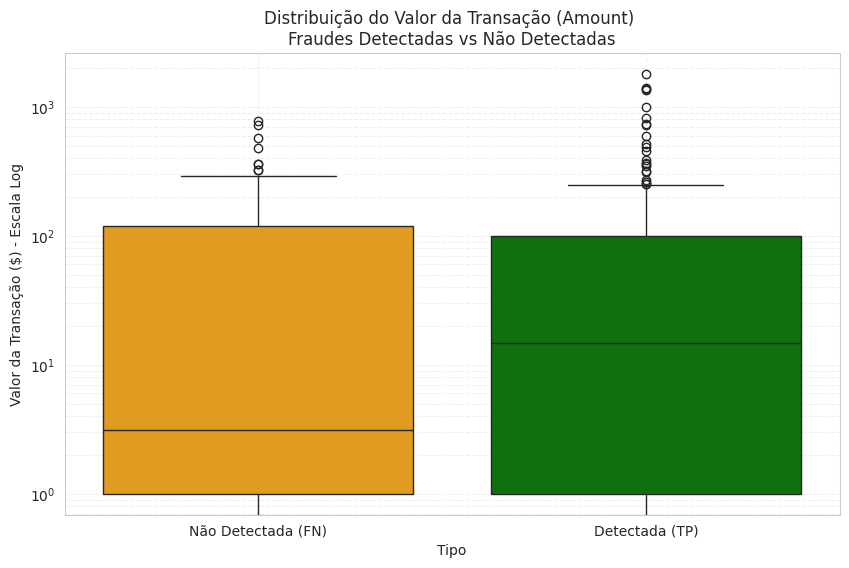

In [65]:
# Comparar distribuições de valores
plt.figure(figsize=(10, 6))
analysis_df = pd.DataFrame({
    'Amount': pd.concat([fn_amounts, tp_amounts]),
    'Tipo': ['Não Detectada (FN)'] * len(fn_amounts) + ['Detectada (TP)'] * len(tp_amounts)
})

sns.boxplot(data=analysis_df, x='Tipo', y='Amount', palette={'Não Detectada (FN)': 'orange', 'Detectada (TP)': 'green'}, hue='Tipo')
plt.yscale('log')
plt.title('Distribuição do Valor da Transação (Amount) \nFraudes Detectadas vs Não Detectadas')
plt.ylabel('Valor da Transação ($) - Escala Log')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.show()

In [66]:
print("CONCLUSÃO DA ANÁLISE:")
if fn_amounts.mean() < tp_amounts.mean():
    print(">> O modelo tende a ignorar fraudes de VALOR MENOR (mais parecidas com gastos normais).")
else:
    print(">> O valor da transação não parece ser o fator decisivo para a falha.")

CONCLUSÃO DA ANÁLISE:
>> O modelo tende a ignorar fraudes de VALOR MENOR (mais parecidas com gastos normais).


## Variational Autoencoder

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Camada customizada para o "Reparameterization Trick"
# Permite que o gradiente flua através da amostragem estocástica
class Sampling(layers.Layer):
    """Usa (z_mean, z_log_var) para amostrar z, o vetor que representa o dado."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Modelo VAE Customizado (Herança de Classe)
# Necessário para customizar o cálculo da Loss combinada (Reconstrução + KL)
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # Trackers para exibir métricas durante o treino
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    # Passo de treinamento customizado
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # 1. Loss de Reconstrução (Qualidade da cópia)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(data - reconstruction), axis=1
                )
            )

            # 2. Loss de Divergência KL (Regularização da distribuição latente)
            # Força o espaço latente a seguir uma distribuição normal
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        # Backpropagation
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    # Passo de validação (Crucial para o Keras 3+ não quebrar)
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        # Cálculo das losses sem gradiente
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.square(data - reconstruction), axis=1
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

### Arquitetura

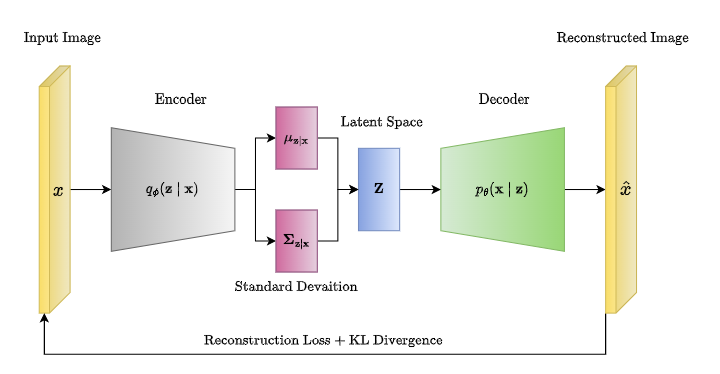

In [ ]:
### Arquitetura VAE

input_dim = X_train_normal.shape[1]
latent_dim = 8 # Espaço latente probabilístico

# --- Encoder ---
encoder_inputs = keras.Input(shape=(input_dim,))
x = layers.Dense(32, activation="relu")(encoder_inputs)
x = layers.Dense(16, activation="relu")(x)

# Saídas duplas: Média e Variância do espaço latente
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var]) # Amostragem

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# --- Decoder ---
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Dense(32, activation="relu")(x)
decoder_outputs = layers.Dense(input_dim, activation="linear")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

### Treino

In [ ]:
### Treino VAE

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

print("Iniciando treinamento do VAE...")
history_vae = vae.fit(
    X_train_normal,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_data=(X_val, X_val),
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    ]
)

Iniciando treinamento do VAE...
Epoch 1/50
3099/3099 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - kl_loss: 4.1680 - loss: 26.1873 - reconstruction_loss: 22.0193 - val_kl_loss: 1.1880 - val_loss: 23.1268 - val_reconstruction_loss: 21.9388
Epoch 2/50
3099/3099 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - kl_loss: 1.4544 - loss: 18.5836 - reconstruction_loss: 17.1292 - val_kl_loss: 1.6638 - val_loss: 21.0893 - val_reconstruction_loss: 19.4255
Epoch 3/50
3099/3099 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - kl_loss: 1.6726 - loss: 17.0694 - reconstruction_loss: 15.3968 - val_kl_loss: 1.6283 - val_loss: 20.4849 - val_reconstruction_loss: 18.8565
Epoch 4/50
3099/3099 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - kl_loss: 1.6162 - loss: 16.5300 - reconstruction_loss: 14.9138 - val_kl_loss: 1.6657 - val_loss: 20.0167 - val_reconstruction_loss: 18.3510
Epoch 5/50
3099/3099 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - kl_loss: 1.6388 - loss: 16.2839 - reconstruction_loss: 14.6451 - val_kl_loss: 1.6474 - val_loss: 19.7614 - val_reconstruction_l

### Avaliação

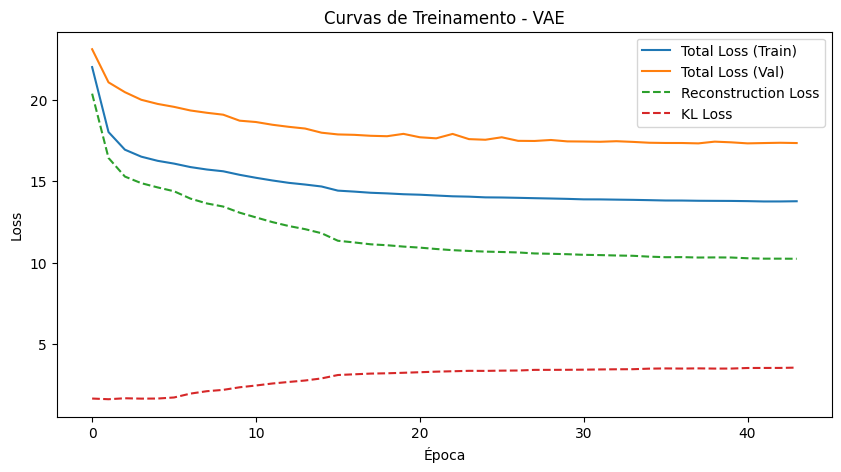

In [ ]:
### Avaliação VAE

plt.figure(figsize=(10, 5))
plt.plot(history_vae.history['loss'], label='Total Loss (Train)')
plt.plot(history_vae.history['val_loss'], label='Total Loss (Val)')
plt.plot(history_vae.history['reconstruction_loss'], label='Reconstruction Loss', linestyle='--')
plt.plot(history_vae.history['kl_loss'], label='KL Loss', linestyle='--')
plt.title('Curvas de Treinamento - VAE')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
print("\nCalculando AUC-ROC do VAE...")

X_test_pred_vae = vae.predict(X_test)
mse_test_vae = np.mean(np.power(X_test - X_test_pred_vae, 2), axis=1)

auc_vae = roc_auc_score(y_test, mse_test_vae)
print(f"AUC-ROC Score (VAE): {auc_vae:.4f}")

print("-" * 40)
print("COMPARAÇÃO DE MODELOS (AUC-ROC)")
print(f"Autoencoder Padrão: {roc_auc_score(y_test, mse_test):.4f} (Se calculado anteriormente)")
print(f"Variational AE    : {auc_vae:.4f}")
print("-" * 40)


Calculando AUC-ROC do VAE...
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
AUC-ROC Score (VAE): 0.9344
----------------------------------------
COMPARAÇÃO DE MODELOS (AUC-ROC)
Autoencoder Padrão: 0.9572 (Se calculado anteriormente)
Variational AE    : 0.9344
----------------------------------------


# **Avaliação e Validação Estatística**

In [ ]:
#Consolidação de Métricas

In [ ]:
#Visualização de Resultados

In [ ]:
#Teste de Significância Estatística

In [ ]:
#Análise de Falhas